# 1. Introdução
O notebook abaixo apresenta e implementa o spot-checking de modelos preditivos supervisionados, desenvolvido para primeiro trabalho da disciplina Aprendizado de Máquina da Universidade Federal do Rio Grande do Sul (2024/2).

Neste trabalho, buscamos analisar a relação de diversos fatores, como gênero e notas do primeiro semestre, com a taxa de desistência de alunos. No modelo abaixo usamos o dataset carregado nesse notebook, analisamos quais os fatores que de fato influenciam na desistência dos alunos e possibilitamos que inputs personalizados sejam adicionados ao modelo para que seja calculado a probabilidade de um aluno desistir do curso.


## Setup

In [ ]:
!pip install pandas plotly matplotlib seaborn scikit-learn xgboost

In [ ]:
# Módulo para leitura e manipulação dos dados
import pandas as pd

# Módulo para manipulação de arrays e matrizes
import numpy as np

# Módulos para visualização de dados e plotagem de gráficos
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Módulos específicos da sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest

# Biblioteca com algoritmos específicos de machine learning
from xgboost import XGBClassifier

# Módulo para balanceamento de classes
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# 1. Coleta de dados

Dataset de https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data

Original: https://zenodo.org/records/5777340#.Y7FJotJBwUE

In [ ]:
import os

if not os.path.exists('../data/student-dropout.zip'):
    !curl -L -o ./data/student-dropout.zip 'https://www.kaggle.com/api/v1/datasets/download/thedevastator/higher-education-predictors-of-student-retention'
    !unzip ./data/student-dropout.zip -d ./data
else:
    print("File already exists. Skipping download.")

curl: (3) URL rejected: Port number was not a decimal number between 0 and 65535
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
data = pd.read_csv("../data/dataset.csv")

# 2. Análise Exploratória dos Dados

O objetivo é entender melhor e sumarizar as características dos dados, analisando quantidade e tipos de atributos, verificando distribuição do atributo alvo, identificando padrões e anomalias, removendo atributos que pareçam irrelevantes ou problemáticos, etc. Utilize gráficos e sumarizações estatísticas para a EDA. Verifique potenciais problemas nos dados, como por exemplo, a necessidade de normalizar os atributos, balancear classes, ou remover instâncias ou atributos por inconsistências nos dados.

Objetivo: compreender como as variáveis do dataset se relacionam com a probabilidade de desistência da universidade.

- P1. Qual a quantidade e tipos de atributos? Existem inconsistências?
  - Quais são os atributos disponíveis? Dentre eles, quais são os categóricos, e quais são os numéricos?
  - Existem inconsistências nos atributos? (Atributos vazios, potenciais erros, etc)
  - Existem atributos que necessitam ser removidos ou transformados?
- P2. Qual a distribuição do atributo alvo?
  - Quais são as classes alvo? Qual a distribuição entre as classes? Está balanceada ou desbalanceada?
- P3. Quais os padrões e anomalias dos atributos individuais?
  - Quais as relações entre as variávies numéricas e categóricas?
- P4. Quais os padrões e anomalias entre todos os atributos?
  - Qual o range dos atributos numéricos? Eles necessitam ser normalizados?




## P1. Qual a quantidade e tipos de atributos?

**Quantidade de atributos**

In [ ]:
data.info(verbose = False, memory_usage = False, show_counts = True) # mostra o tipo e a quantidade de itens não nulos de cada coluna

Existem 35 atributos, onde um é o atributo alvo ('Target') e os outros 34 são potenciais atributos treináveis.

In [ ]:
data.head()

**Tipos de atributos**

In [ ]:
data.dtypes

O atributo alvo é codificado como tipo object, o que significa um ponteiro que aponta para strings. 

Os 34 atributos potencialmente treináveis estão codificados como atributos numéricos float64 ou int64. Todavia, pela descrição do conjunto de dados, alguns destes parâmetros são categóricos e foram codificados para int64.

Isto dificulta a interpreteação dos gráficos e análise entre atributos categóricos e numéricos. Para isto, reconstruímos os atributos categóricos em um novo DataFrame através das informações do data descriptor deste dataset [[1](https://doi.org/10.3390/data7110146)] 

Como nosso objetivo de aprendizado é separar os dados entre evasão e permanência, este último que pode ser matriculado (enrolled) ou graduado (graduated), juntamos estas labels através destas traduções/localizações.

In [ ]:
data['Target'].head()

In [ ]:
data['Target'] = data['Target'].map({
    'Dropout': 'Evasão',
    'Enrolled': 'Permanência',
    'Graduate': 'Permanência'
})

data['Target'].head()

Em primeiro lugar, separamos manualmente, com base no descritor, o nome dos atributos em duas listas.

In [ ]:
categorical_nominal = ['Application mode', 'Course', 'Previous qualification', 'Nacionality',
       "Mother's qualification", "Father's qualification",
       "Mother's occupation", "Father's occupation"]

categorical_binary = ['Marital status', 'Daytime/evening attendance', 'Displaced', 'Gender', 'International', 'Educational special needs',
                      'Debtor', 'Tuition fees up to date', 'Scholarship holder', 'Target']

categorical_data = categorical_nominal + categorical_binary

numerical_data = ['Application order', 'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)', 'Unemployment rate',
       'Inflation rate', 'GDP', 'Age at enrollment']


print(len(categorical_nominal), len(categorical_binary), len(numerical_data))

len(categorical_nominal)

In [ ]:
data[numerical_data].head()

Criamos um dicionário dos dados categóricos, a partir do descritor do conjunto de dados [1] e com auxílio do Github Copilot para acelerar a transcrição.

In [ ]:
# Dicionário de dados

data_cat = data.copy(deep=True)

data_cat['Marital status'] = data['Marital status'].map({
    1: 'Single',
    2: 'Married',
    3: 'Widower',
    4: 'Divorced',
    5: 'Facto union',
    6: 'Legally separated'
})

data_cat['Nacionality'] = data['Nacionality'].map({
    1: 'Portuguese',
    2: 'German',
    3: 'Spanish',
    4: 'Italian',
    5: 'Dutch',
    6: 'English',
    7: 'Lithuanian',
    8: 'Angolan',
    9: 'Cape Verdean',
    10: 'Guinean',
    11: 'Mozambican',
    12: 'Santomean',
    13: 'Turkish',
    14: 'Brazilian',
    15: 'Romanian',
    16: 'Moldova (Republic of)',
    17: 'Mexican',
    18: 'Ukrainian',
    19: 'Russian',
    20: 'Cuban',
    21: 'Colombian'
})

data_cat['Application mode'] = data['Application mode'].map({
    1: '1st phase—general contingent',
    2: 'Ordinance No. 612/93',
    3: '1st phase—special contingent (Azores Island)',
    4: 'Holders of other higher courses',
    5: 'Ordinance No. 854-B/99',
    6: 'International student (bachelor)',
    7: '1st phase—special contingent (Madeira Island)',
    8: '2nd phase—general contingent',
    9: '3rd phase—general contingent',
    10: 'Ordinance No. 533-A/99, item b2) (Different Plan)',
    11: 'Ordinance No. 533-A/99, item b3 (Other Institution)',
    12: 'Over 23 years old',
    13: 'Transfer',
    14: 'Change in course',
    15: 'Technological specialization diploma holders',
    16: 'Change in institution/course',
    17: 'Short cycle diploma holders',
    18: 'Change in institution/course (International)'
})

data_cat['Course'] = data['Course'].map({
    1: 'Biofuel Production Technologies',
    2: 'Animation and Multimedia Design',
    3: 'Social Service (evening attendance)',
    4: 'Agronomy',
    5: 'Communication Design',
    6: 'Veterinary Nursing',
    7: 'Informatics Engineering',
    8: 'Equiniculture',
    9: 'Management',
    10: 'Social Service',
    11: 'Tourism',
    12: 'Nursing',
    13: 'Oral Hygiene',
    14: 'Advertising and Marketing Management',
    15: 'Journalism and Communication',
    16: 'Basic Education',
    17: 'Management (evening attendance)'
})

data_cat['Previous qualification'] = data['Previous qualification'].map({
    1: 'Secondary education',
    2: 'Higher education—bachelor’s degree',
    3: 'Higher education—degree',
    4: 'Higher education—master’s degree',
    5: 'Higher education—doctorate',
    6: 'Frequency of higher education',
    7: '12th year of schooling—not completed',
    8: '11th year of schooling—not completed',
    9: 'Other—11th year of schooling',
    10: '10th year of schooling',
    11: '10th year of schooling—not completed',
    12: 'Basic education 3rd cycle (9th/10th/11th year) or equivalent',
    13: 'Basic education 2nd cycle (6th/7th/8th year) or equivalent',
    14: 'Technological specialization course',
    15: 'Higher education—degree (1st cycle)',
    16: 'Professional higher technical course',
    17: 'Higher education—master’s degree (2nd cycle)'
})

parents_qualification_mapping = {
    1: 'Secondary Education—12th Year of Schooling or Equivalent',
    2: 'Higher Education—bachelor’s degree',
    3: 'Higher Education—degree',
    4: 'Higher Education—master’s degree',
    5: 'Higher Education—doctorate',
    6: 'Frequency of Higher Education',
    7: '12th Year of Schooling—not completed',
    8: '11th Year of Schooling—not completed',
    9: '7th Year (Old)',
    10: 'Other—11th Year of Schooling',
    11: '2nd year complementary high school course',
    12: '10th Year of Schooling',
    13: 'General commerce course',
    14: 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equivalent',
    15: 'Complementary High School Course',
    16: 'Technical-professional course',
    17: 'Complementary High School Course—not concluded',
    18: '7th year of schooling',
    19: '2nd cycle of the general high school course',
    20: '9th Year of Schooling—not completed',
    21: '8th year of schooling',
    22: 'General Course of Administration and Commerce',
    23: 'Supplementary Accounting and Administration',
    24: 'Unknown',
    25: 'Cannot read or write',
    26: 'Can read without having a 4th year of schooling',
    27: 'Basic education 1st cycle (4th/5th year) or equivalent',
    28: 'Basic Education 2nd Cycle (6th/7th/8th Year) or equivalent',
    29: 'Technological specialization course',
    30: 'Higher education—degree (1st cycle)',
    31: 'Specialized higher studies course',
    32: 'Professional higher technical course',
    33: 'Higher Education—master’s degree (2nd cycle)',
    34: 'Higher Education—doctorate (3rd cycle)'
}

data_cat["Mother's qualification"] = data["Mother's qualification"].map(parents_qualification_mapping)
data_cat["Father's qualification"] = data["Father's qualification"].map(parents_qualification_mapping)

parents_occupation_mapping = {
    1: 'Student',
    2: 'Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers',
    3: 'Specialists in Intellectual and Scientific Activities',
    4: 'Intermediate Level Technicians and Professions',
    5: 'Administrative staff',
    6: 'Personal Services, Security and Safety Workers, and Sellers',
    7: 'Farmers and Skilled Workers in Agriculture, Fisheries, and Forestry',
    8: 'Skilled Workers in Industry, Construction, and Craftsmen',
    9: 'Installation and Machine Operators and Assembly Workers',
    10: 'Unskilled Workers',
    11: 'Armed Forces Professions',
    12: 'Other Situation',
    13: '(blank)',
    14: 'Armed Forces Officers',
    15: 'Armed Forces Sergeants',
    16: 'Other Armed Forces personnel',
    17: 'Directors of administrative and commercial services',
    18: 'Hotel, catering, trade, and other services directors',
    19: 'Specialists in the physical sciences, mathematics, engineering, and related techniques',
    20: 'Health professionals',
    21: 'Teachers',
    22: 'Specialists in finance, accounting, administrative organization, and public and commercial relations',
    23: 'Intermediate level science and engineering technicians and professions',
    24: 'Technicians and professionals of intermediate level of health',
    25: 'Intermediate level technicians from legal, social, sports, cultural, and similar services',
    26: 'Information and communication technology technicians',
    27: 'Office workers, secretaries in general, and data processing operators',
    28: 'Data, accounting, statistical, financial services, and registry-related operators',
    29: 'Other administrative support staff',
    30: 'Personal service workers',
    31: 'Sellers',
    32: 'Personal care workers and the like',
    33: 'Protection and security services personnel',
    34: 'Market-oriented farmers and skilled agricultural and animal production workers',
    35: 'Farmers, livestock keepers, fishermen, hunters and gatherers, and subsistence',
    36: 'Skilled construction workers and the like, except electricians',
    37: 'Skilled workers in metallurgy, metalworking, and similar',
    38: 'Skilled workers in electricity and electronics',
    39: 'Workers in food processing, woodworking, and clothing and other industries and crafts',
    40: 'Fixed plant and machine operators',
    41: 'Assembly workers',
    42: 'Vehicle drivers and mobile equipment operators',
    43: 'Unskilled workers in agriculture, animal production, and fisheries and forestry',
    44: 'Unskilled workers in extractive industry, construction, manufacturing, and transport',
    45: 'Meal preparation assistants',
    46: 'Street vendors (except food) and street service providers'
}

data_cat["Mother's occupation"] = data["Mother's occupation"].map(parents_occupation_mapping)
data_cat["Father's occupation"] = data["Father's occupation"].map(parents_occupation_mapping)

data_cat['Gender'] = data['Gender'].map({
    1: 'male',
    0: 'female'
})

data_cat['Daytime/evening attendance'] = data['Daytime/evening attendance'].map({
    1: 'daytime',
    0: 'evening'
})

binary_mapping = {
    'Displaced': {1: 'yes', 0: 'no'},
    'Educational special needs': {1: 'yes', 0: 'no'},
    'Debtor': {1: 'yes', 0: 'no'},
    'Tuition fees up to date': {1: 'yes', 0: 'no'},
    'Scholarship holder': {1: 'yes', 0: 'no'},
    'International': {1: 'yes', 0: 'no'}
}

for column, mapping in binary_mapping.items():
    data_cat[f'{column}'] = data[column].map(mapping)

data_cat['Target'] = data['Target'].copy()

In [ ]:
data_cat.info()

**Quantidade de atributos categóricos e numéricos**

In [ ]:
# Contar a quantidade de atributos categóricos e numéricos
num_categorical = len(data_cat.select_dtypes(include=['object']).columns)
num_numerical = len(data_cat.select_dtypes(include=['number']).columns)

print(f"Quantidade de atributos categóricos: {num_categorical}")
print(f"Quantidade de atributos numéricos: {num_numerical}")

## P2. Qual a distribuição do atributo alvo?

In [ ]:
print(data["Target"].unique())

In [ ]:
data['Target'].describe(include='all')

Percentual de frequência das classes do atributo alvo

In [ ]:
series = data['Target'].value_counts(normalize=True)
print(series)


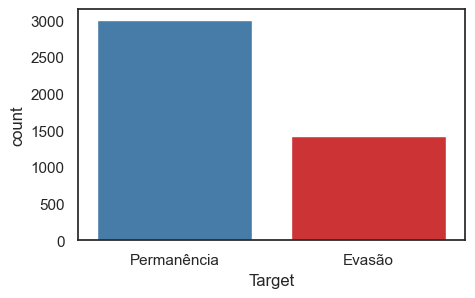

In [ ]:
fig = plt.figure(figsize=(5, 3))

sns.countplot(x = data['Target'], data = data, hue='Target', legend=False, palette='Set1',
                order=data['Target'].value_counts().index)

Existe um **desbalanceamento nas classes do atributo alvo**. A classe 'Graduate', que representa os estudantes formados, tem 31,9% mais instâncias do que 'Enrolled', que representa os estudantes com o curso em andamento.

**Possibilidade de ação**: escolher um método de amostragem para balancear as classes do atributo alvo.

## P3. Quais os padrões e anomalias dos atributos individuais?

### Atributos numéricos - univariados

Gráficos
- Histograma: distribuição de frequência
- Boxplot

Estatísticas descritivas univariadas
- Média (sensível a outliers)
- Mediana (menos sensível a outliers)
- Desvio padrão
- Mínimo e máximo
- Intervalo
- Quartil (Q1, Q2, Intervalo Interquartil, Limites Superior e Inferior)
- Assimetria
- Curtose
- Dados vazios

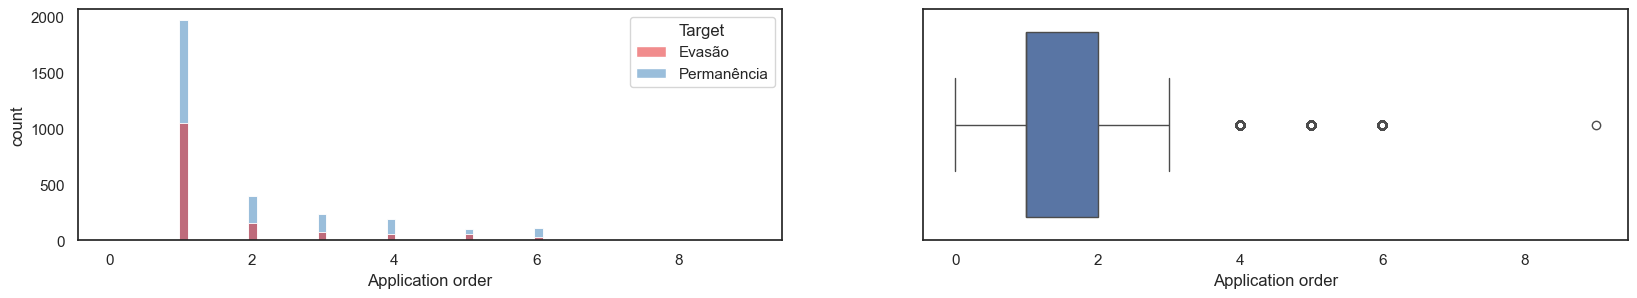

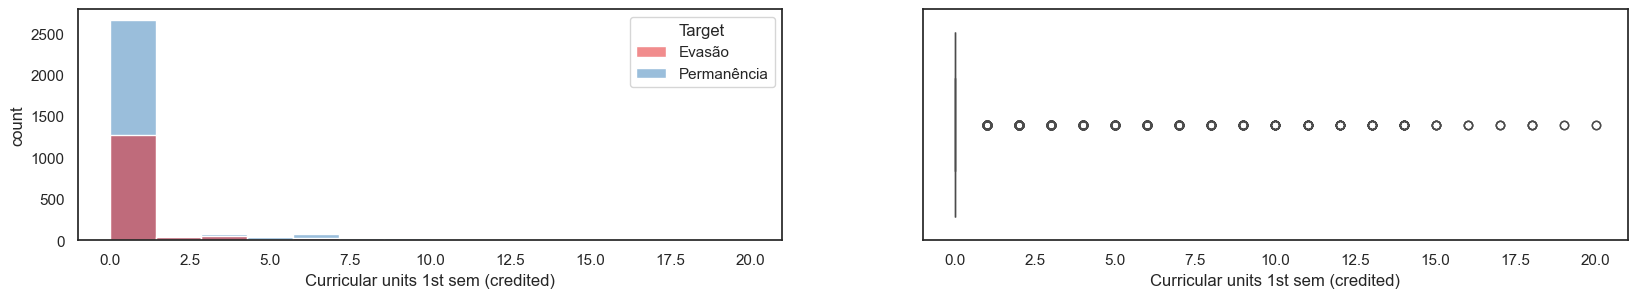

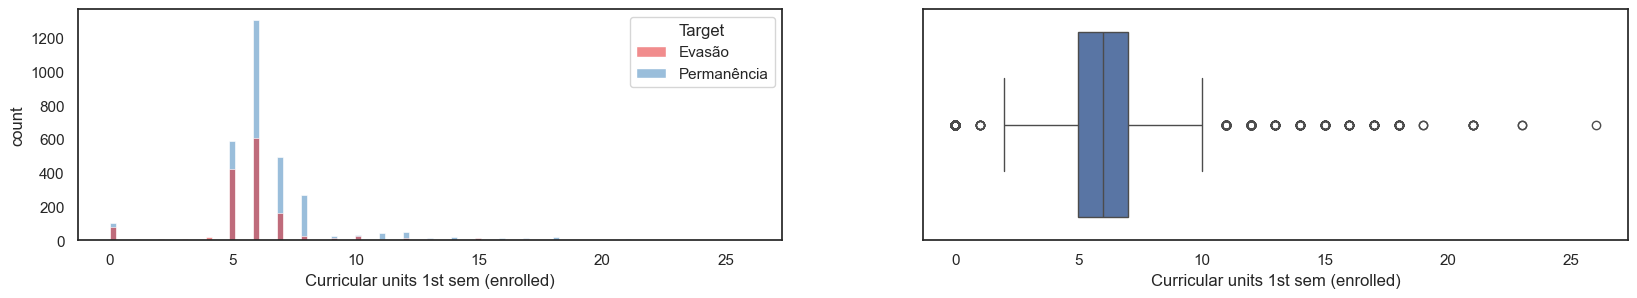

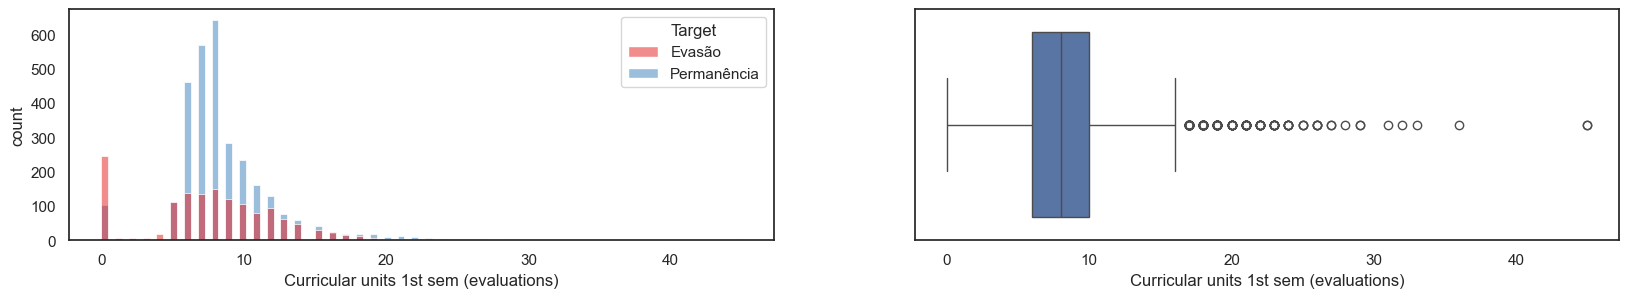

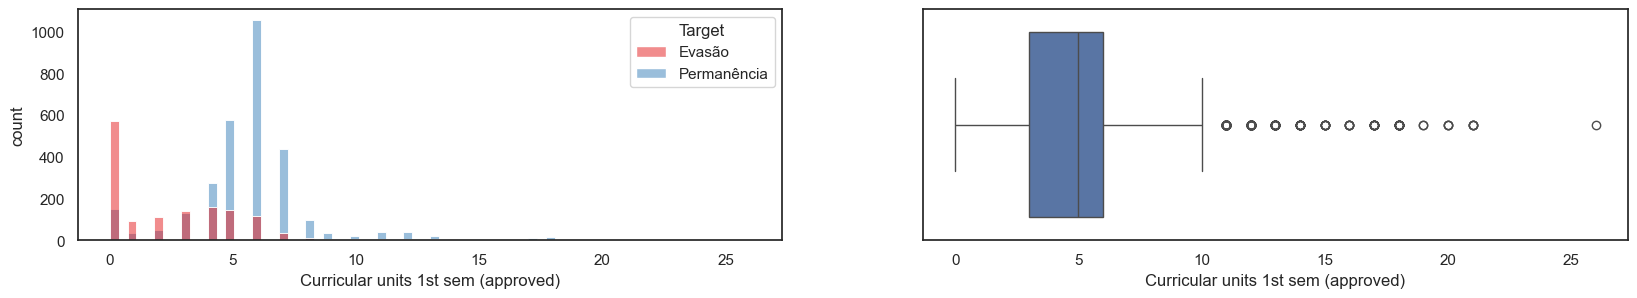

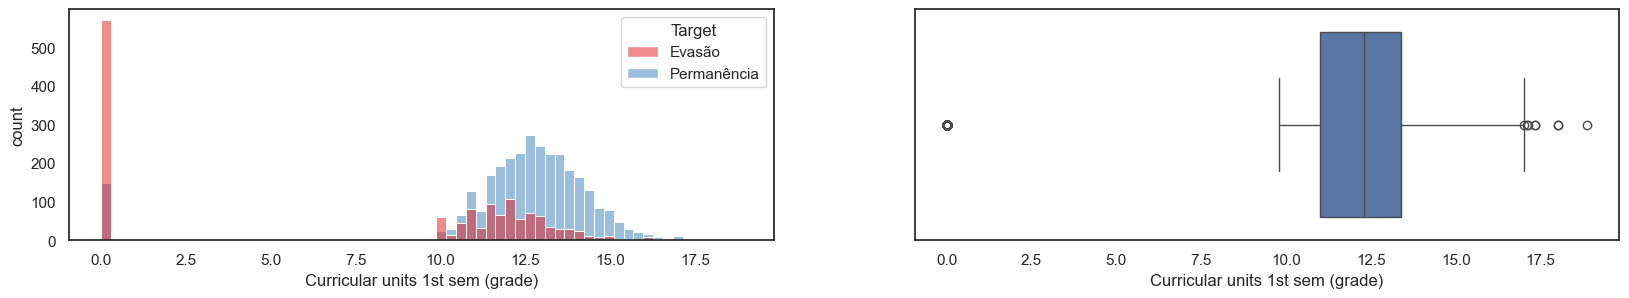

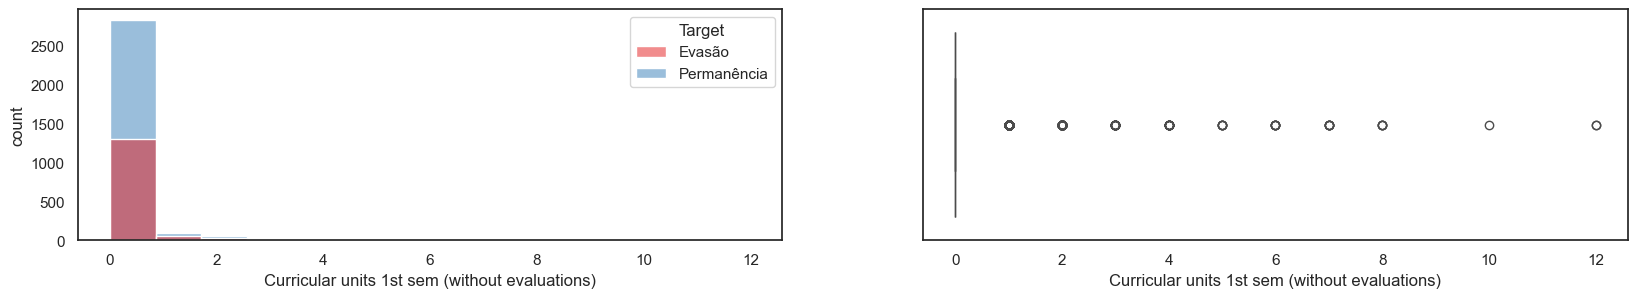

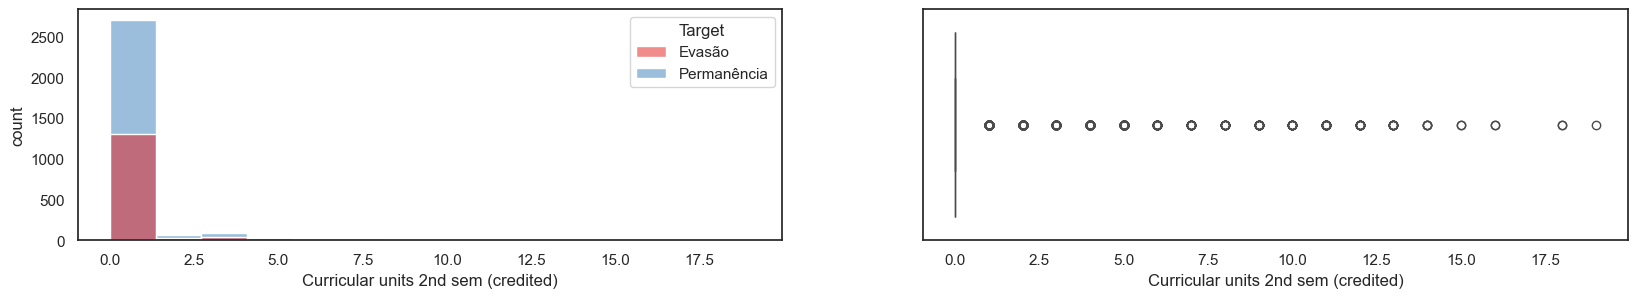

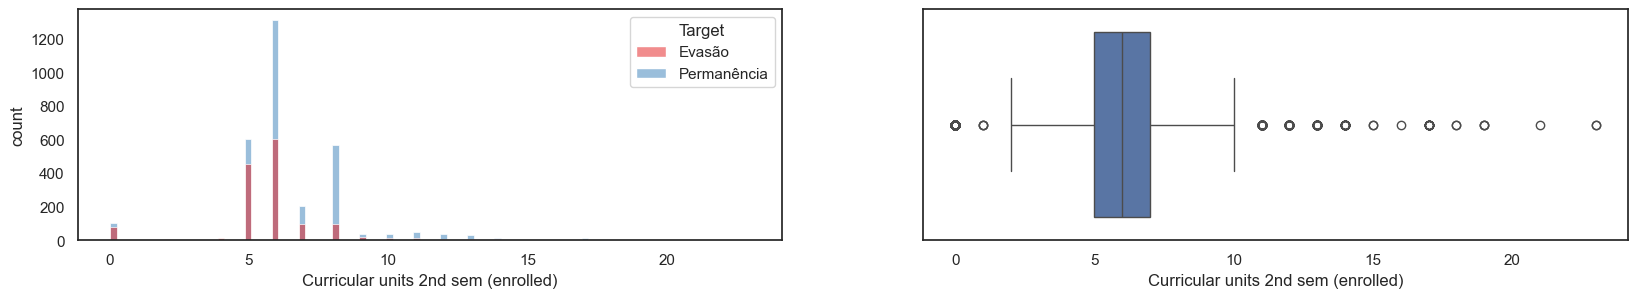

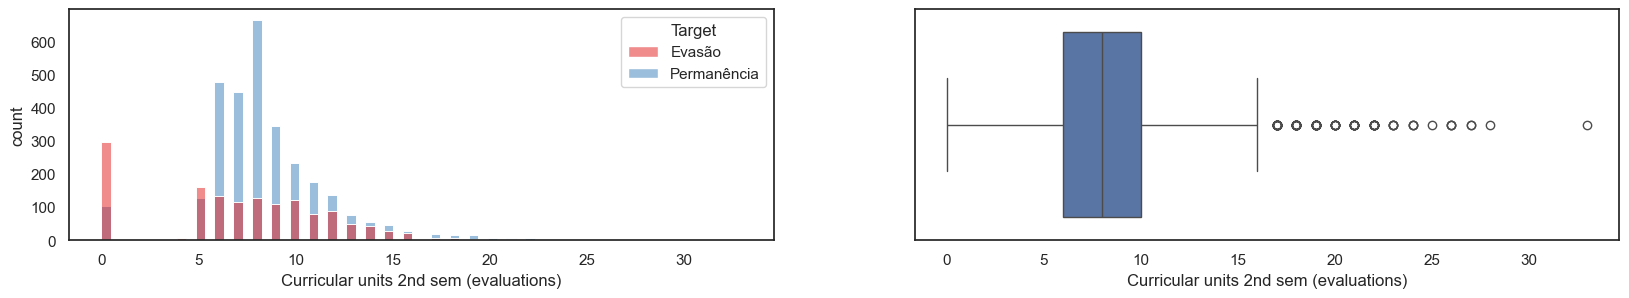

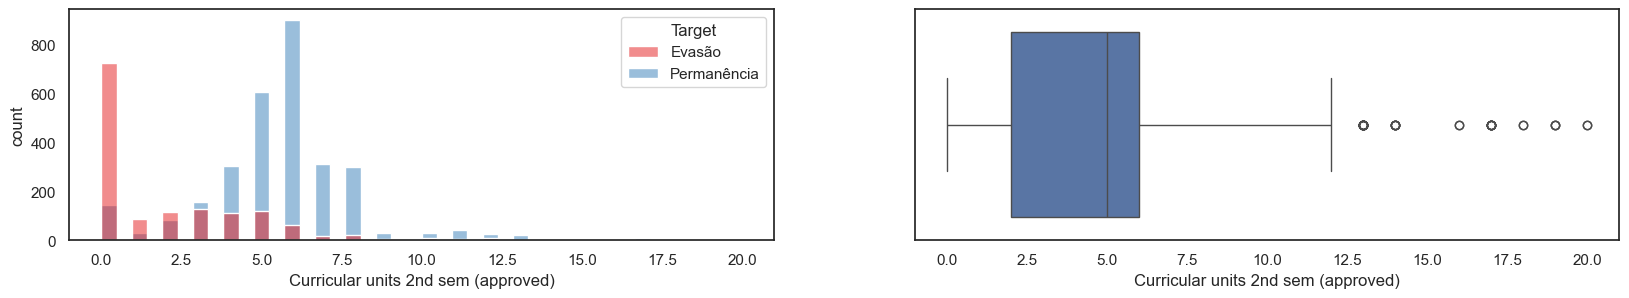

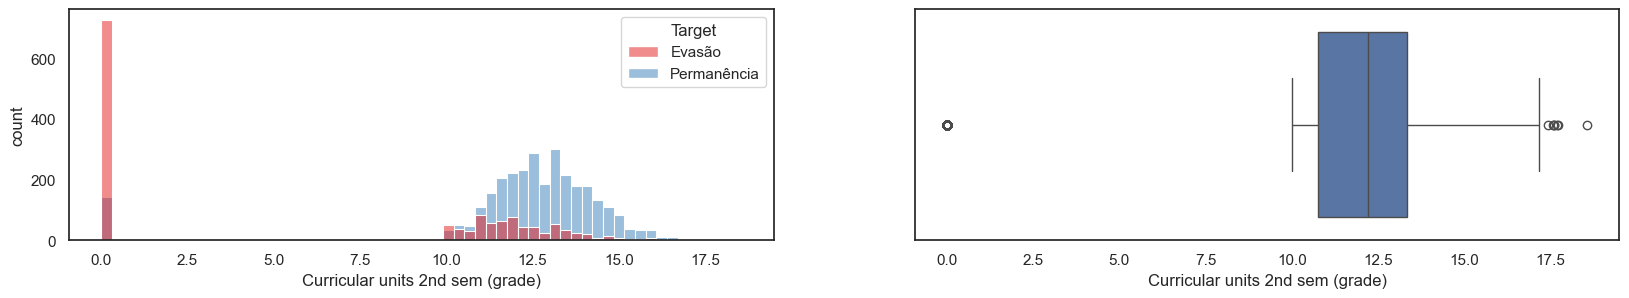

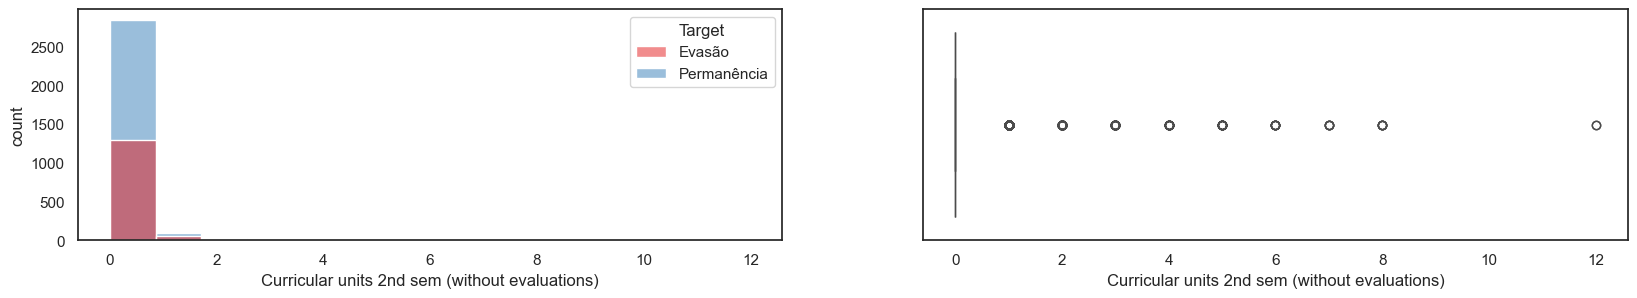

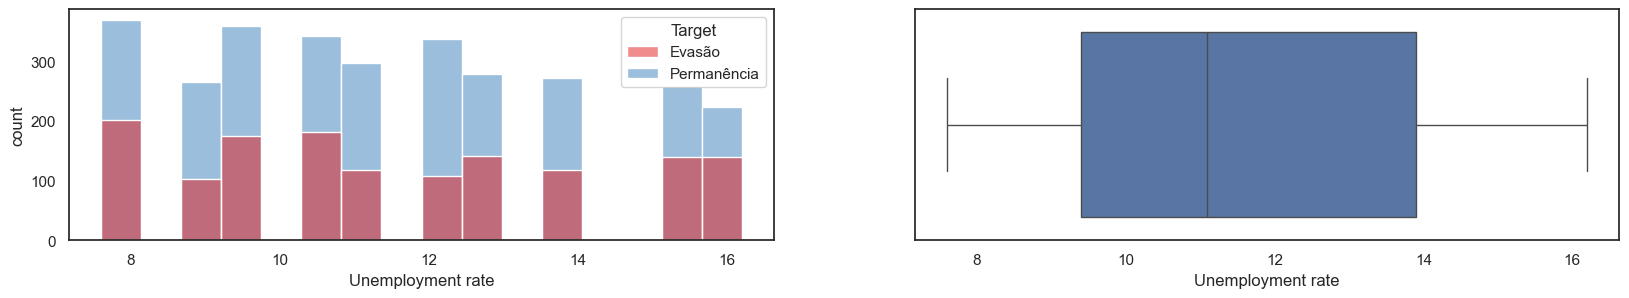

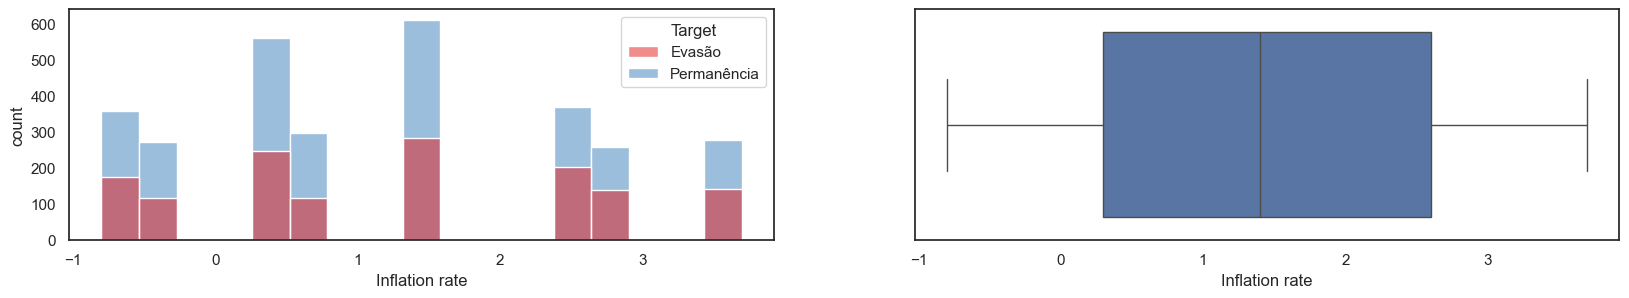

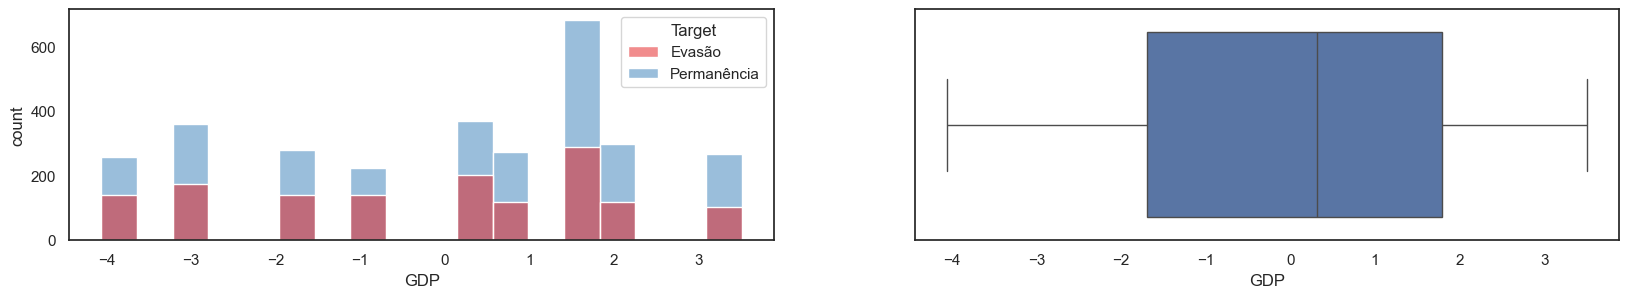

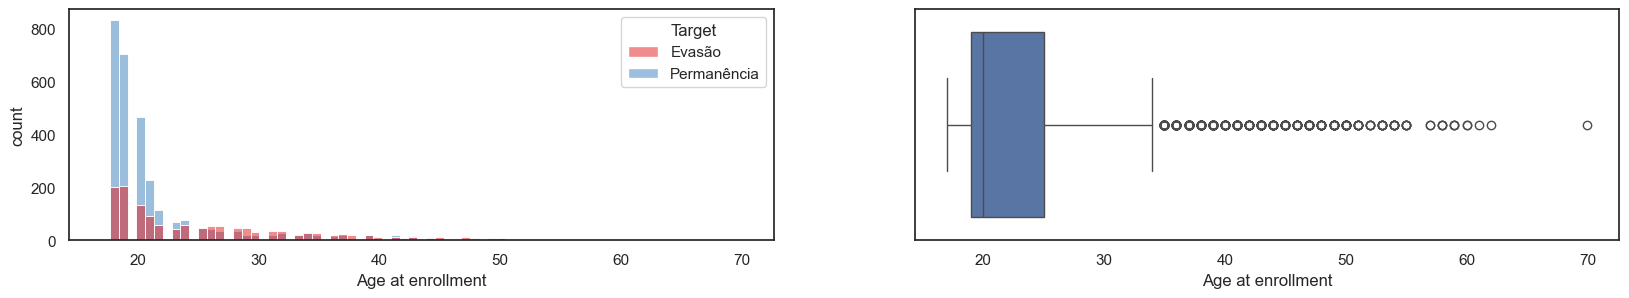

In [ ]:
for col in numerical_data:
    
    # Atributo
    print(col, end="\n\n")

    # Estatísticas descritivas
    print('Média :', round(data[col].mean(), 2))
    print('Mediana :', round(data[col].median(), 2))
    print('Variância :', round(data[col].var(), 2))
    print('Desvio padrão :', round(data[col].std(), 2))
    print('Min :', round(data[col].min(), 2))
    print('Max :', round(data[col].max(), 2))
    print('Intervalo: ', round(data[col].max() - data[col].min(), 2))
    print('Amostras únicas :', data[col].nunique())
    print('Amostras faltando :', data[col].isnull().sum())
    print('Q1 :', round(data[col].quantile(0.25), 2))
    print('Q3 :', round(data[col].quantile(0.75), 2))
    print('IQR :', round(data[col].quantile(0.75) - data[col].quantile(0.25), 2))
    print('Limite inferior :', round(data[col].quantile(0.25) - 1.5 * (data[col].quantile(0.75) - data[col].quantile(0.25)), 2))
    print('Limite superior :', round(data[col].quantile(0.75) + 1.5 * (data[col].quantile(0.75) - data[col].quantile(0.25)), 2))
    print('Obliquidade :', round(data[col].skew(), 2))
    print('Curtose :', round(data[col].kurt(), 2))

    # Gráficos - referência: https://www.analyticsvidhya.com/blog/2022/07/step-by-step-exploratory-data-analysis-eda-using-python/
    plt.figure(figsize = (20, 3))
    plt.subplot(1, 2, 1)
    # data[col].hist(grid=False)
    sns.histplot(data=data, x=col, hue='Target', kde=False, palette='Set1')
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[col])
    plt.show()

### Atributos categóricos
Gráficos:
- Histograma: distribuição de frequência (contagem das classes)

Estatística descritiva:
- Moda

#### a. Distribuição de frequência

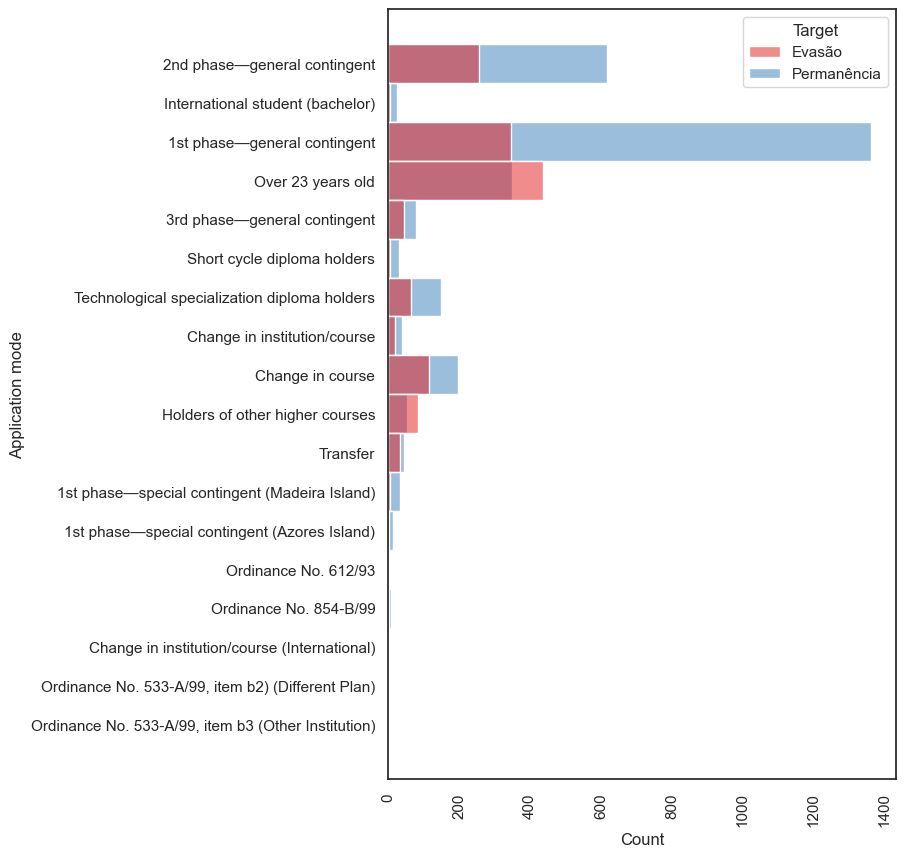

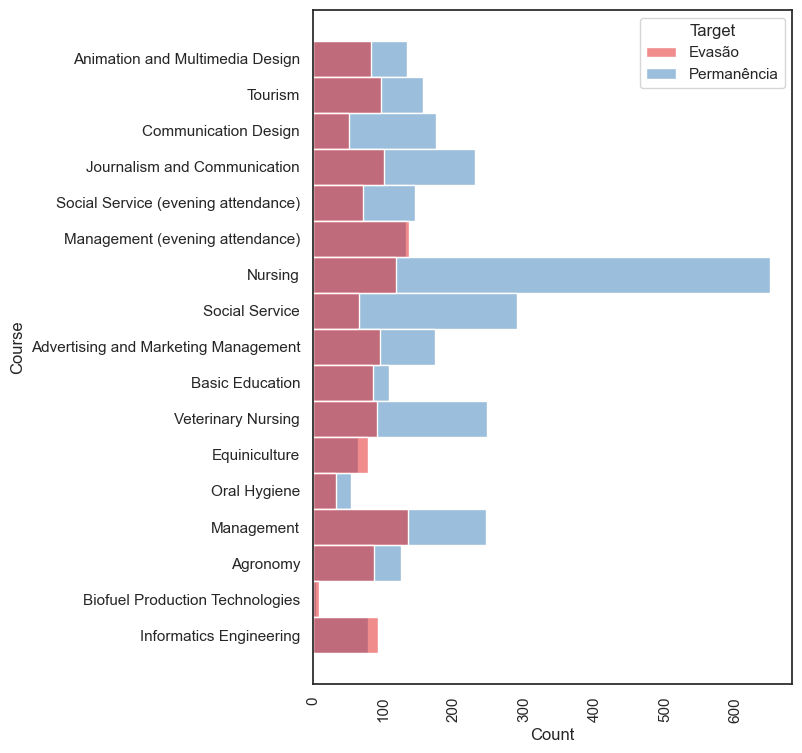

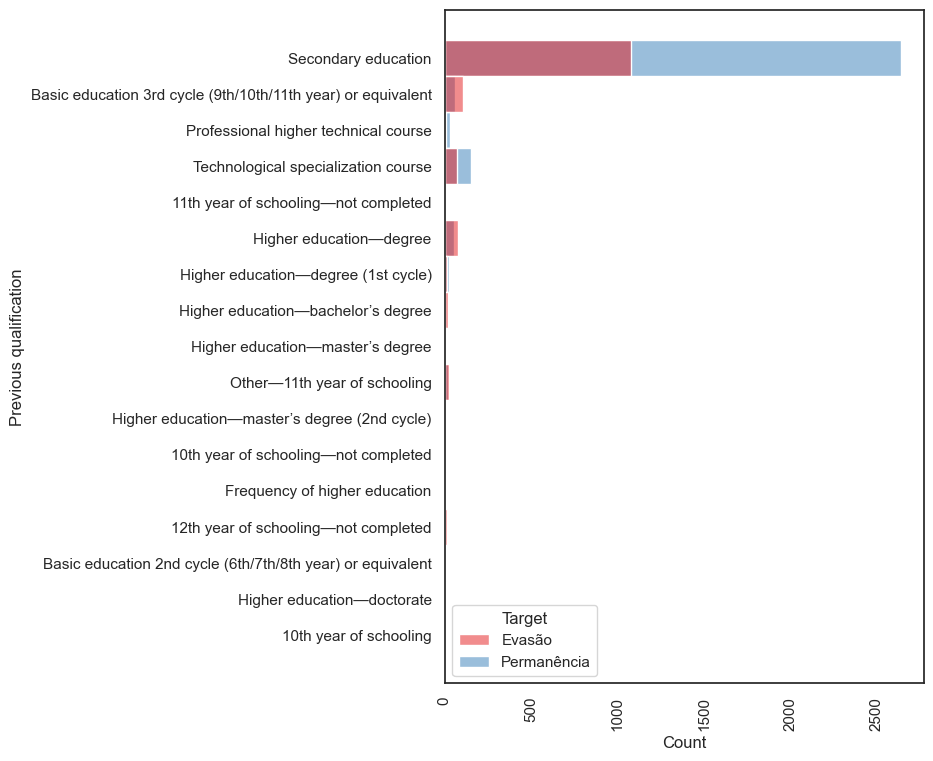

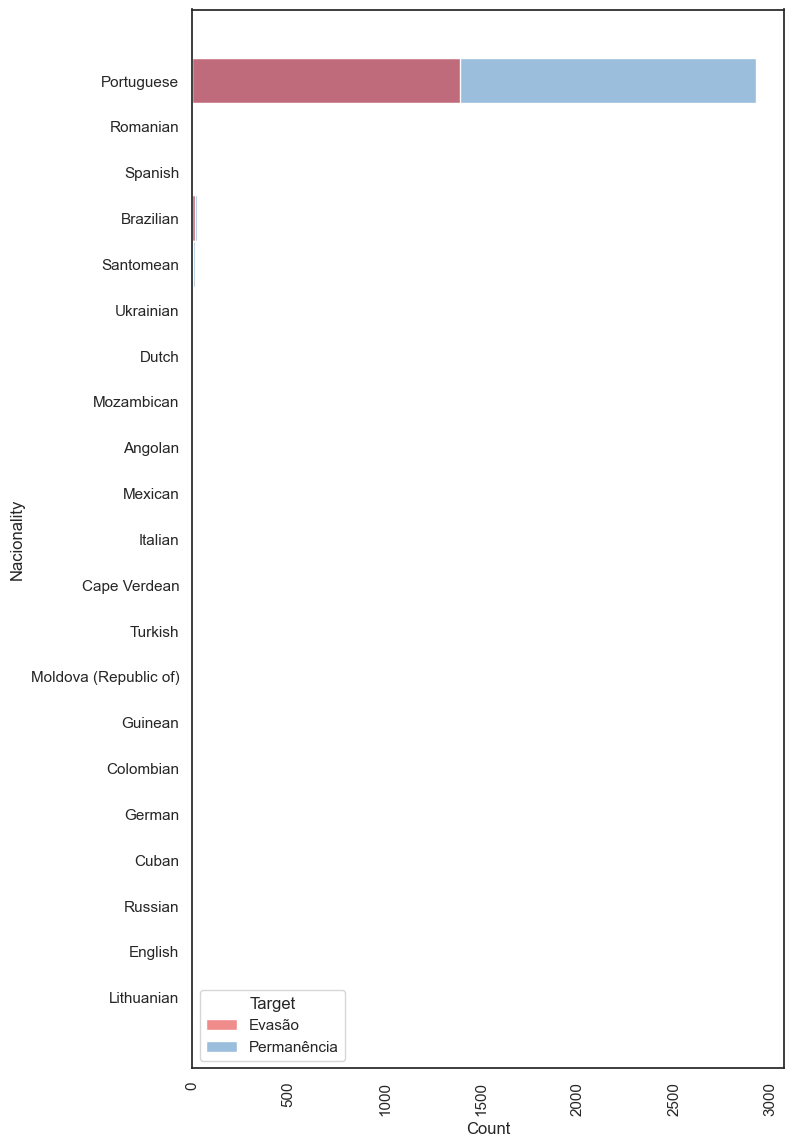

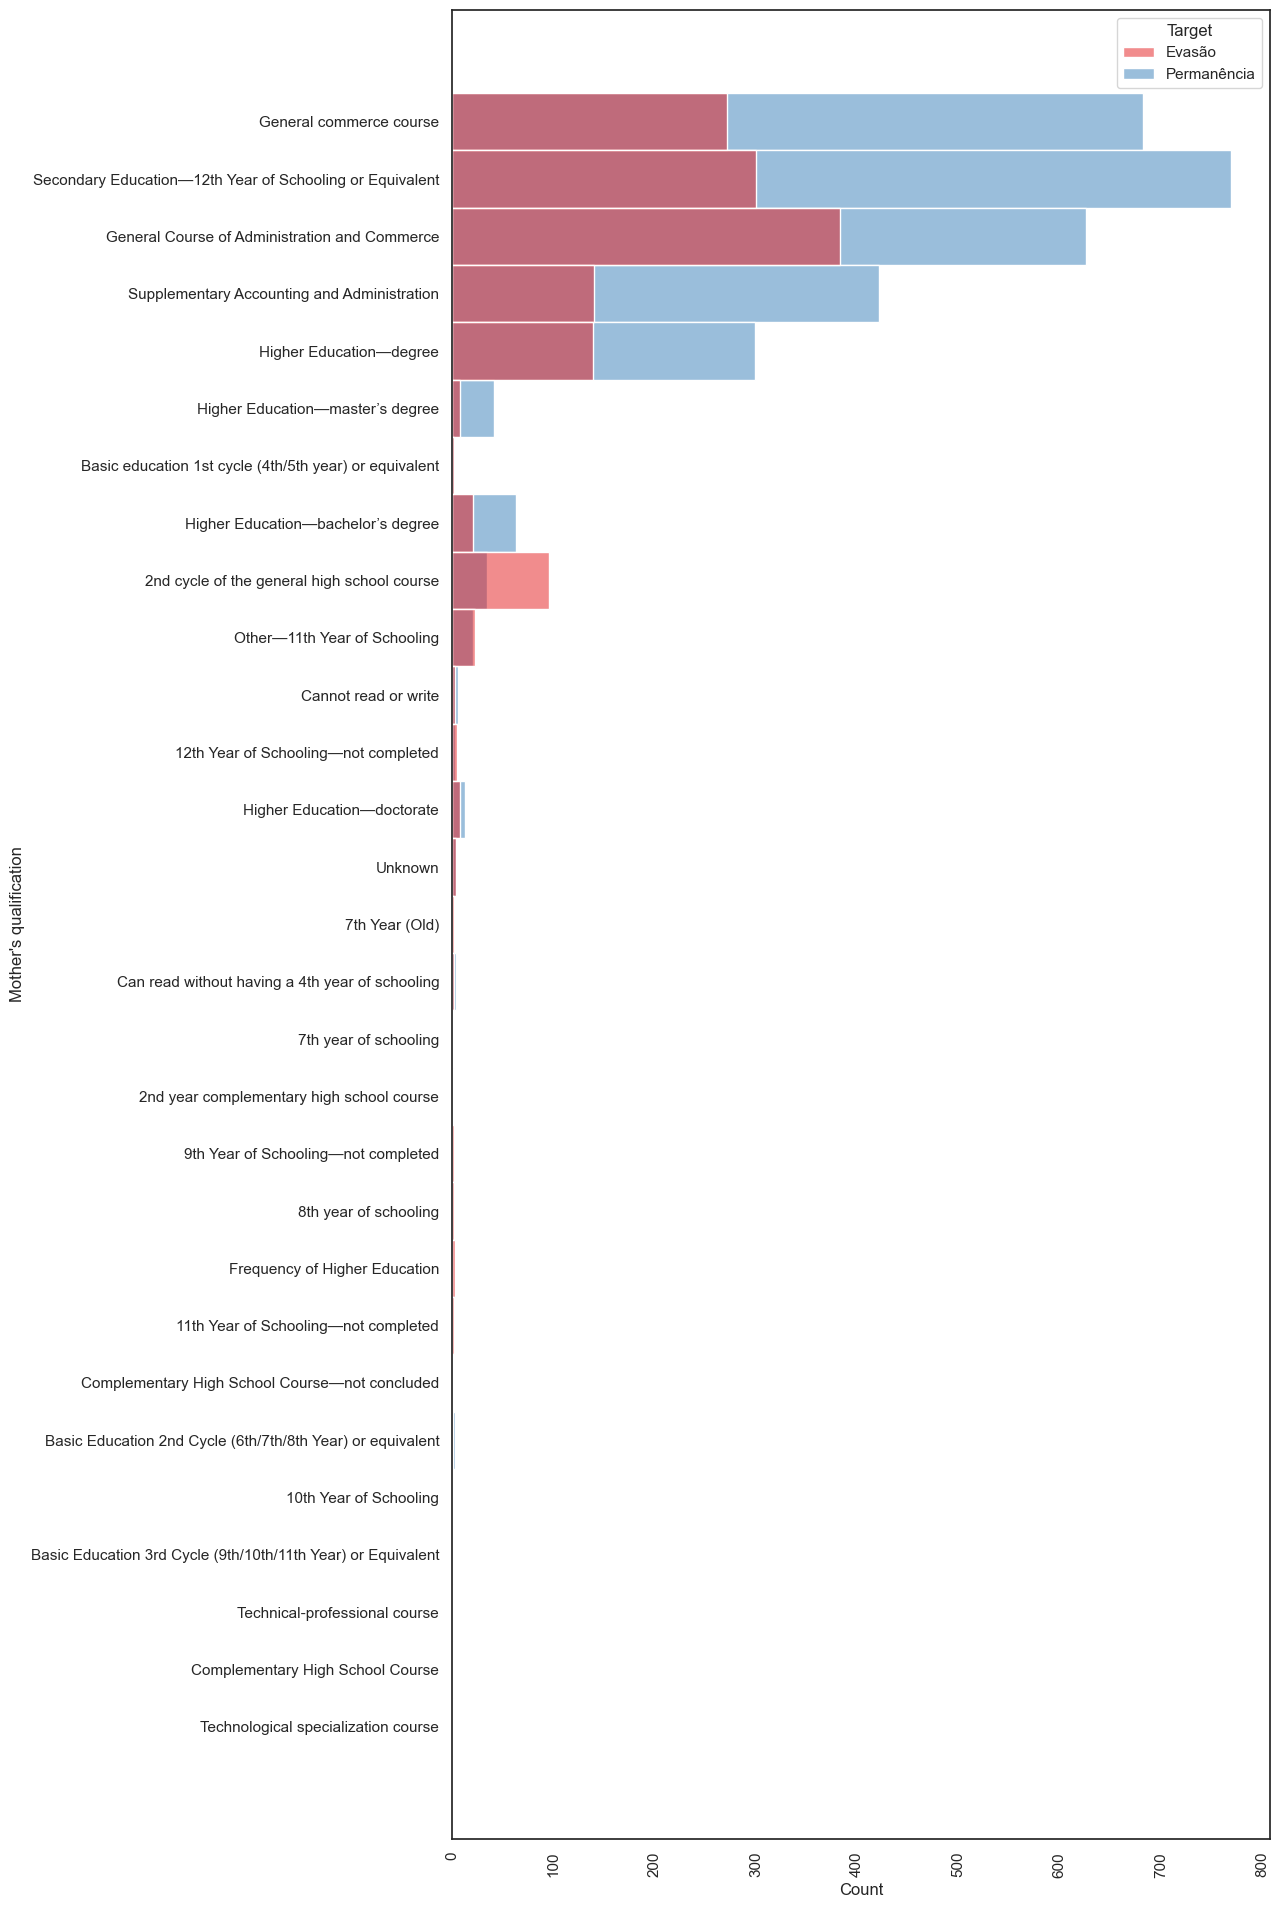

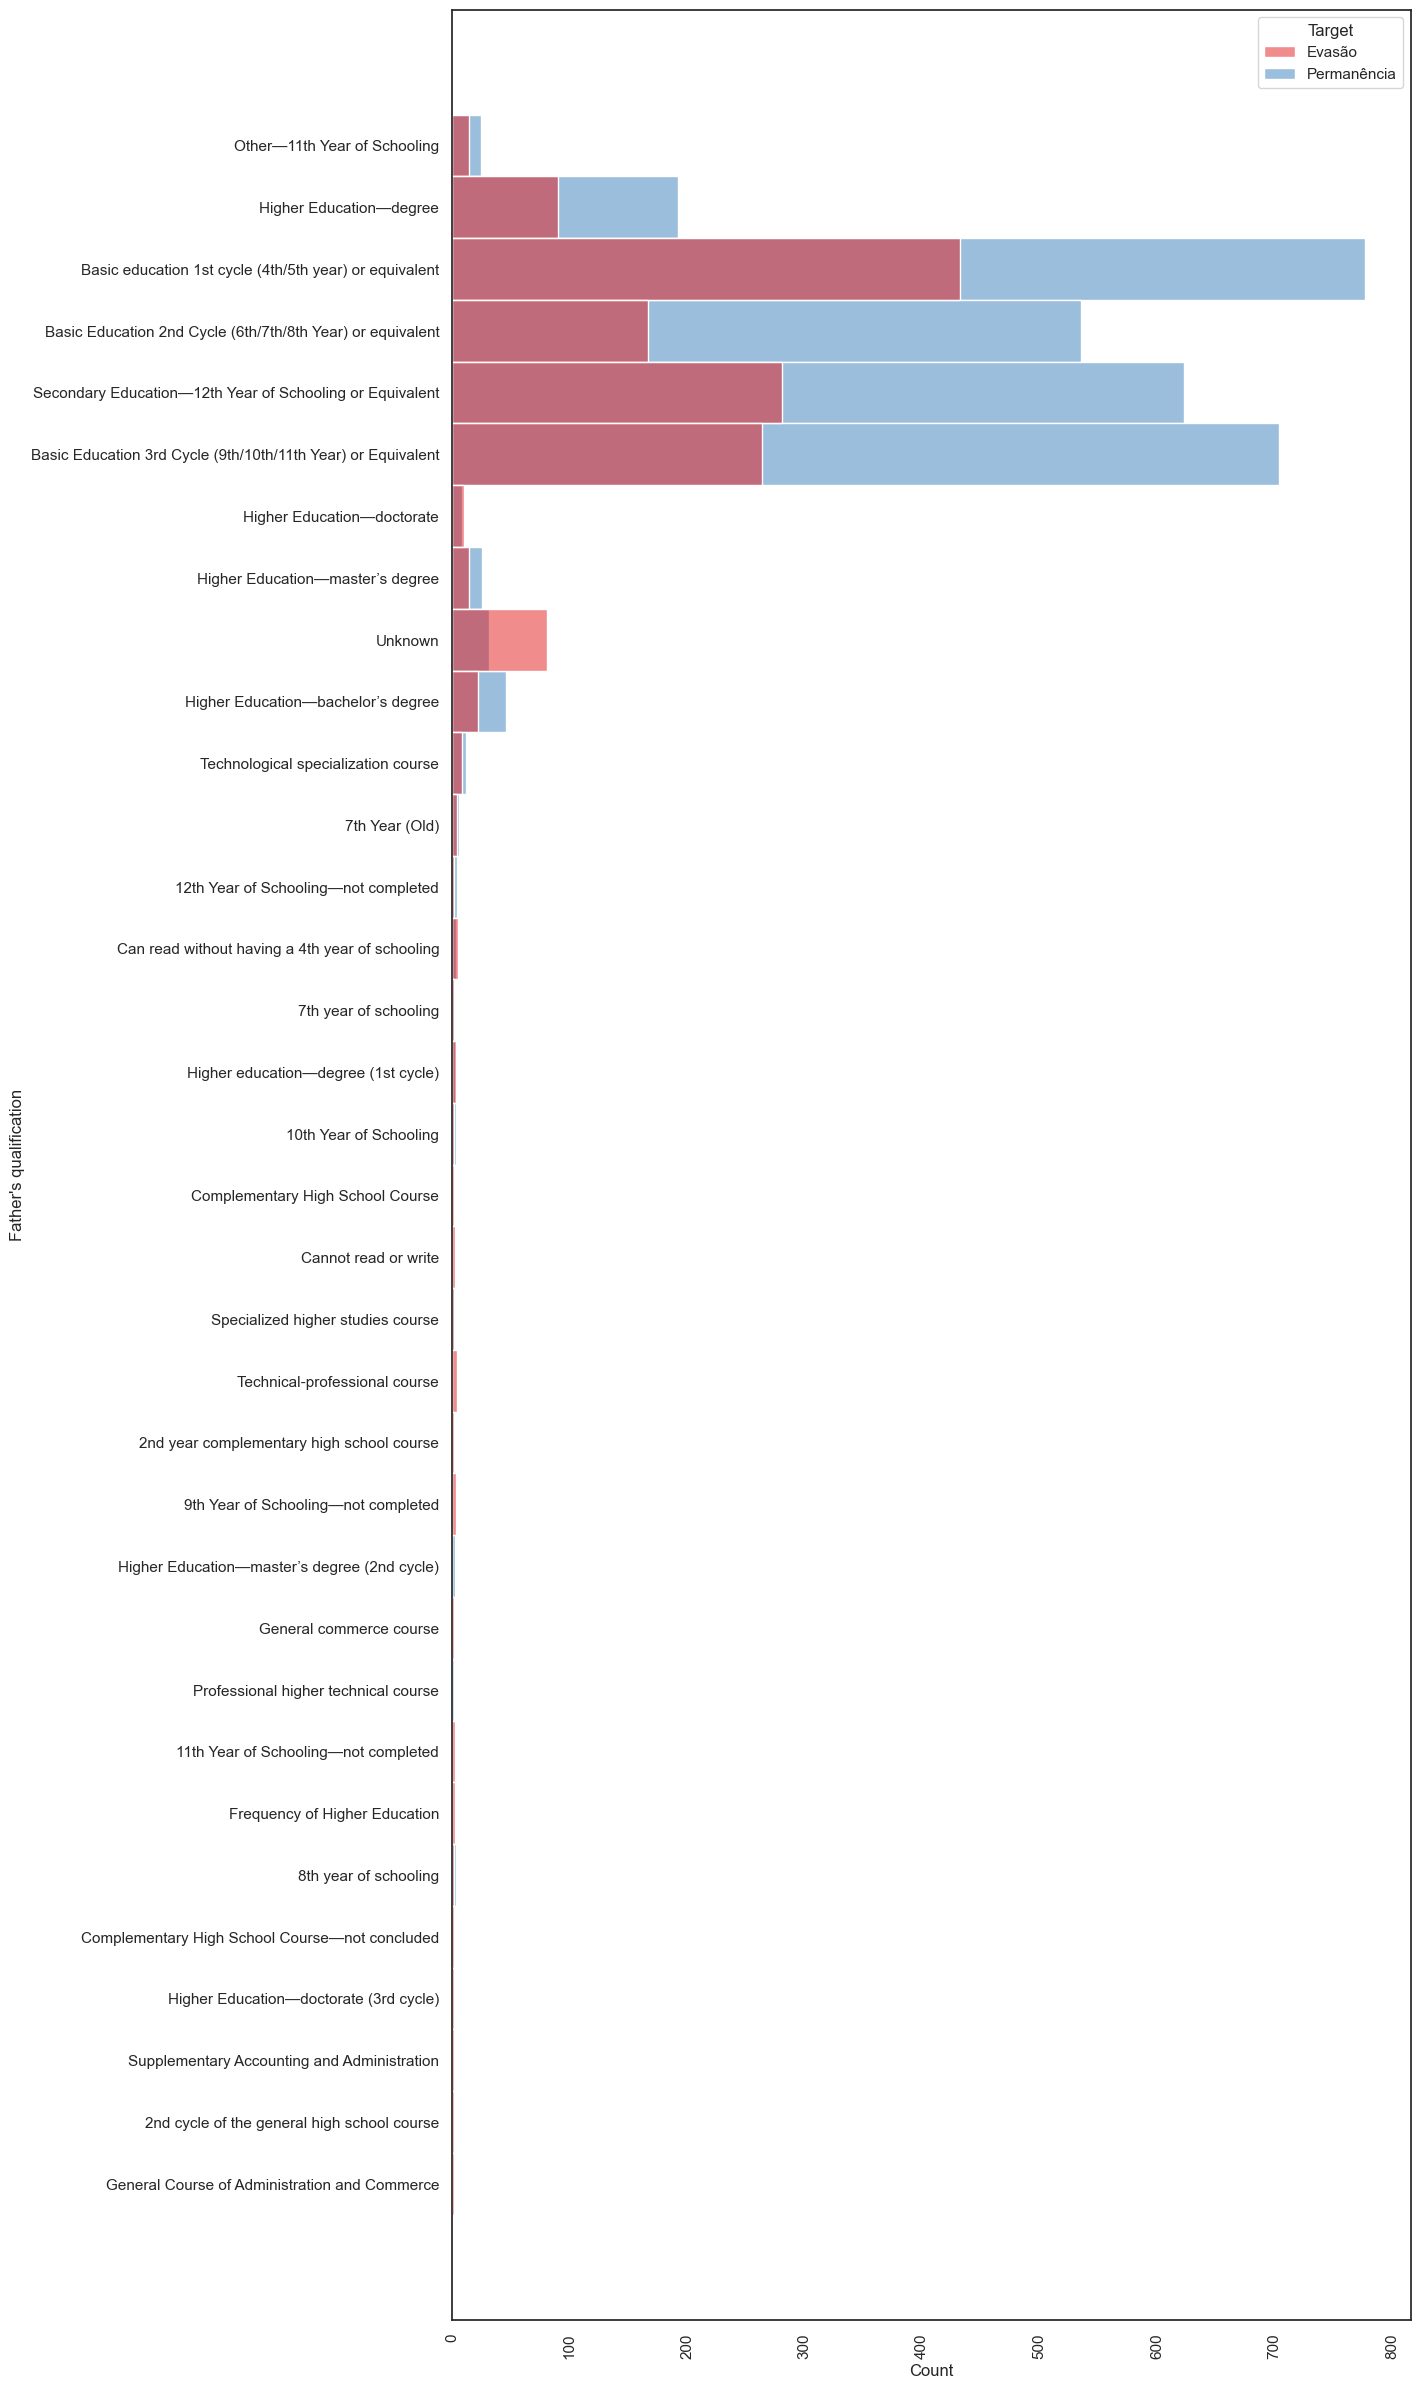

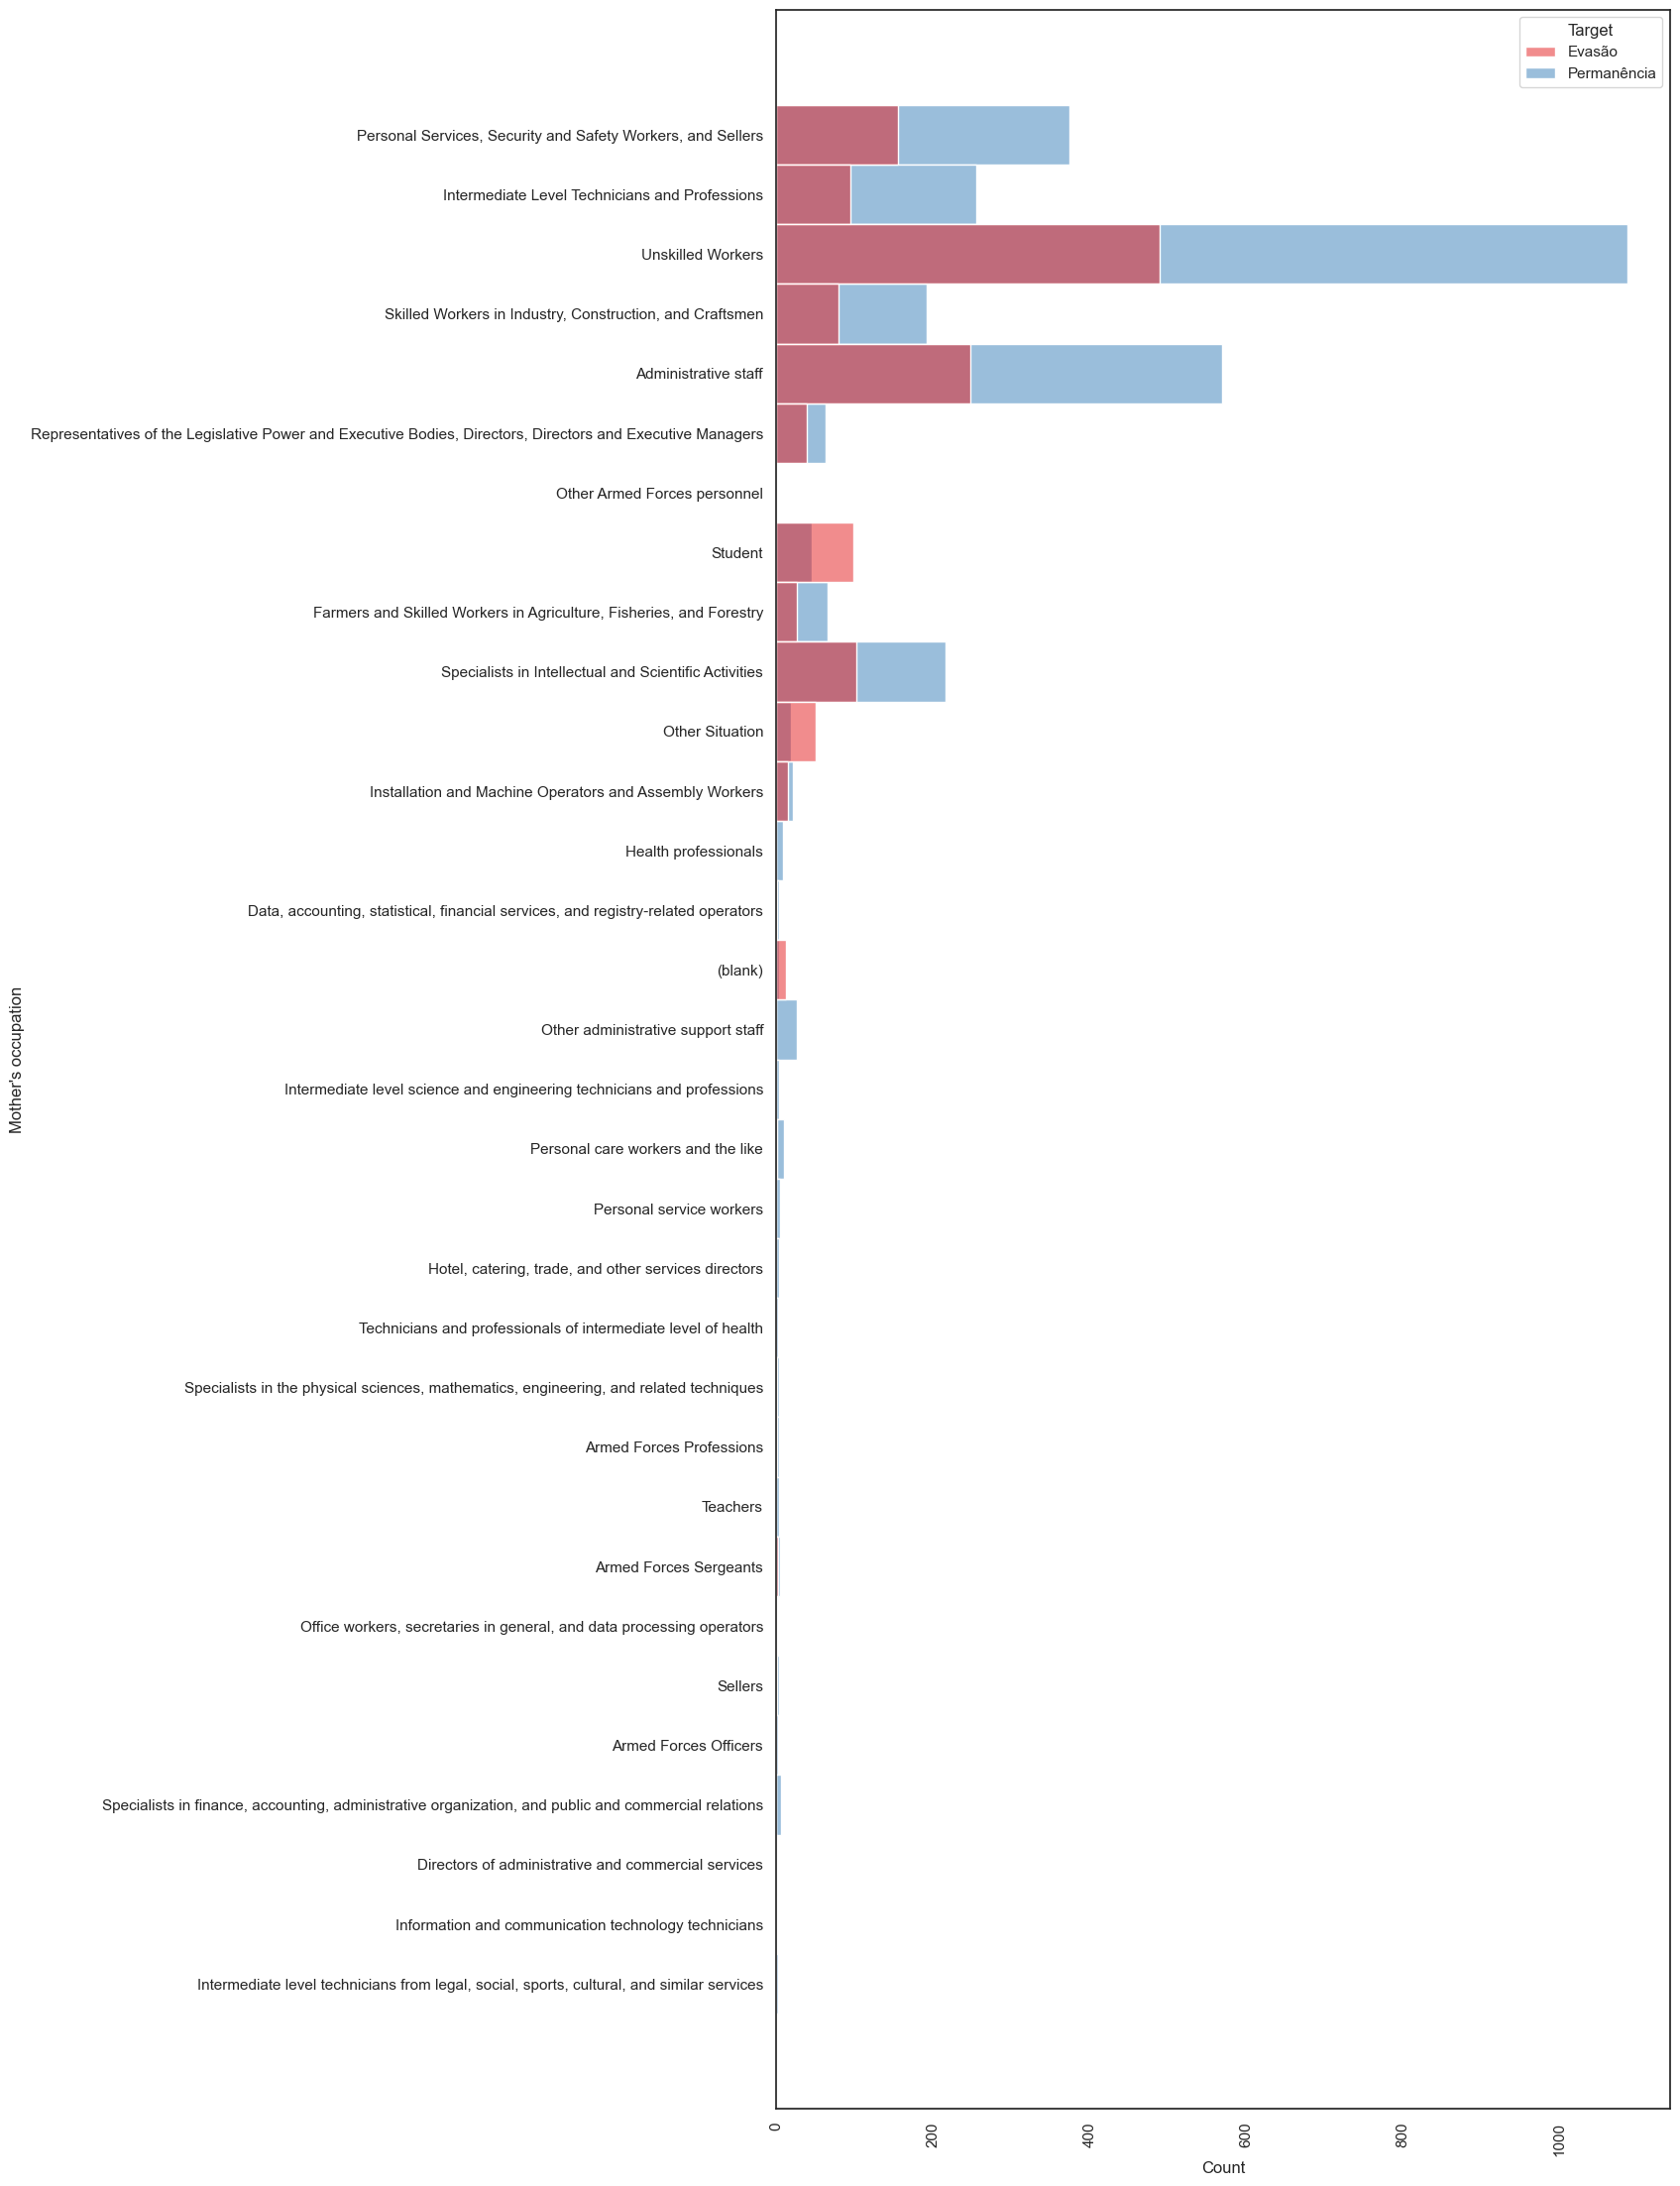

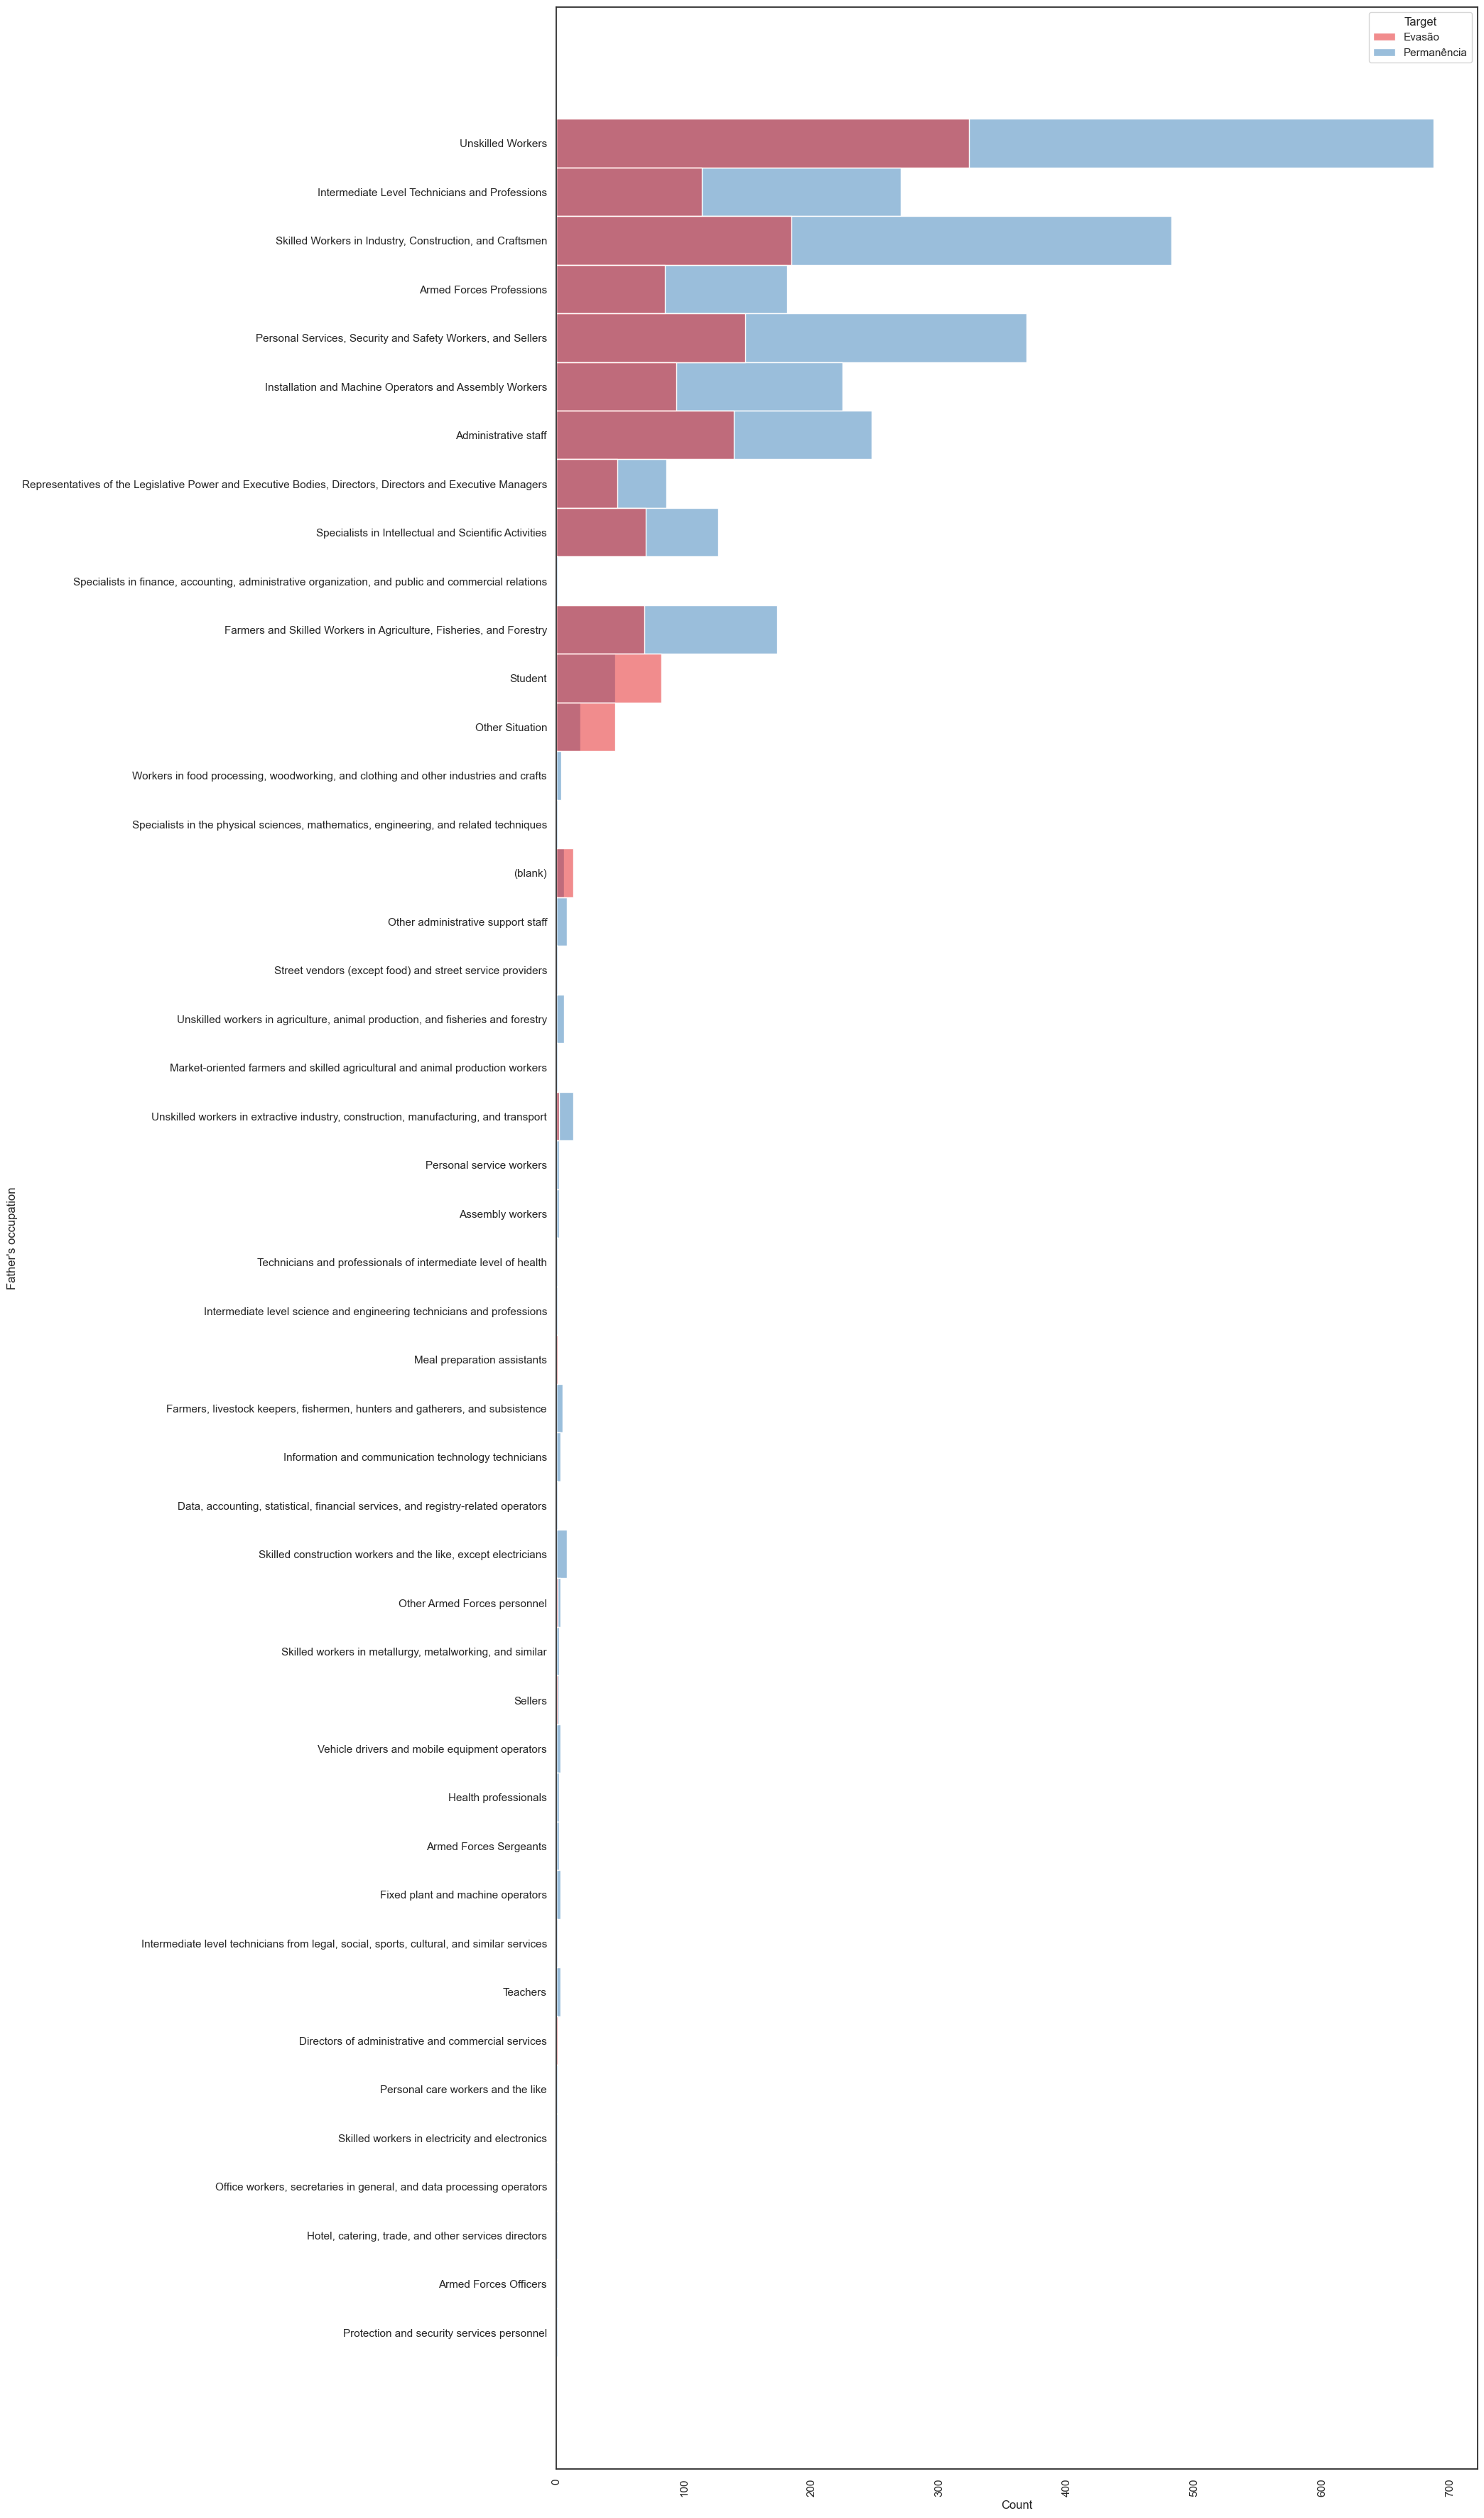

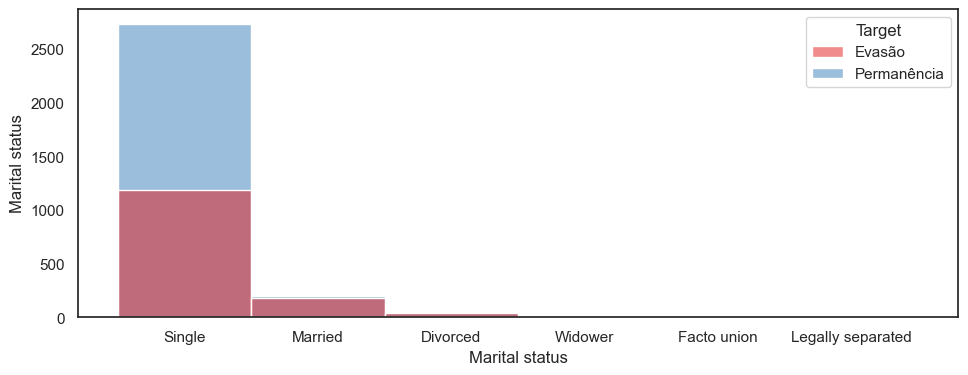

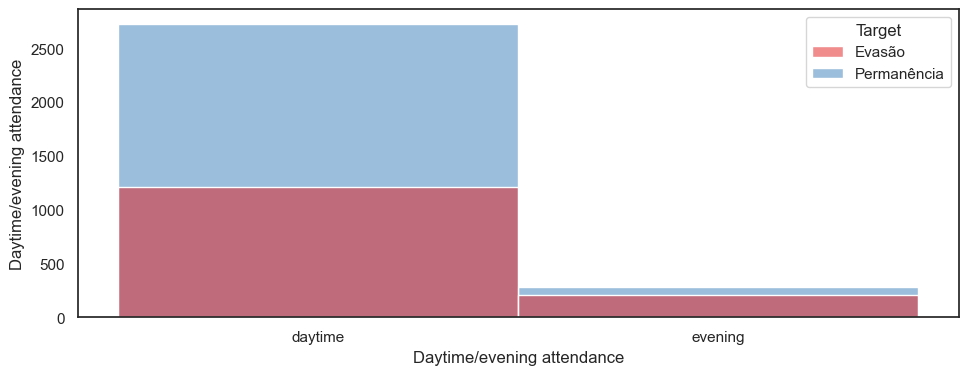

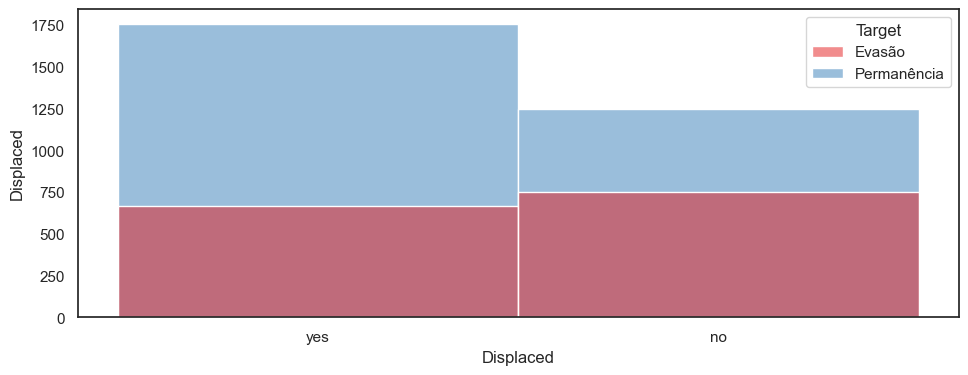

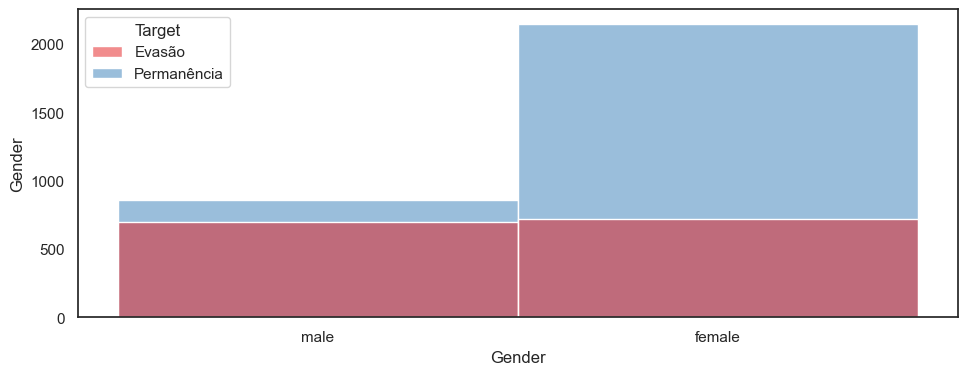

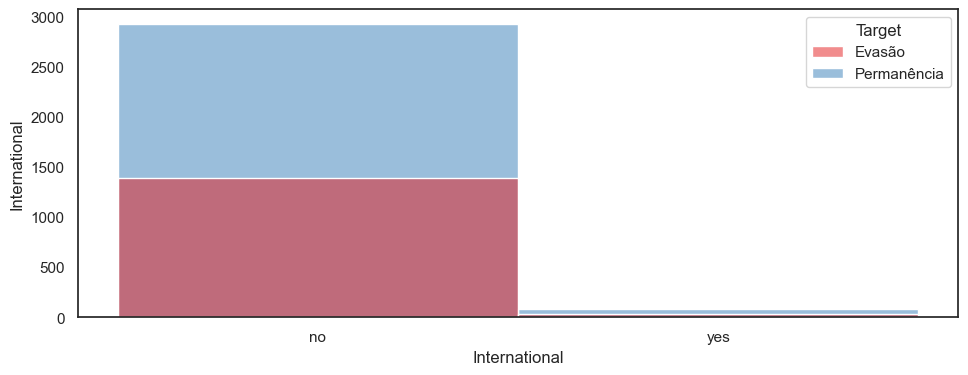

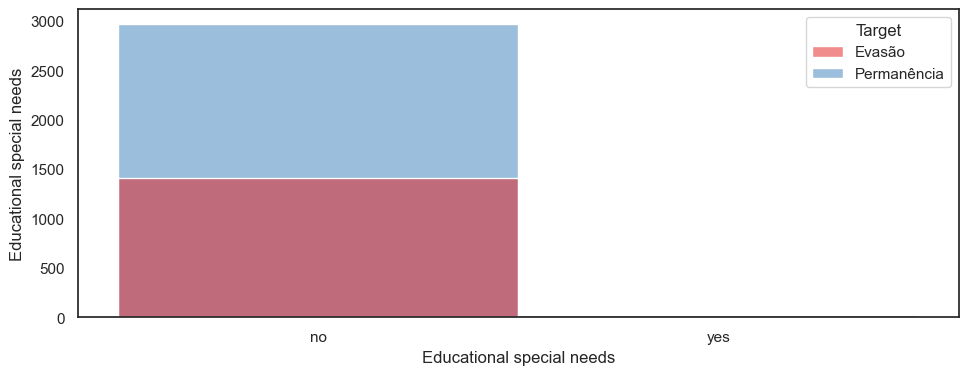

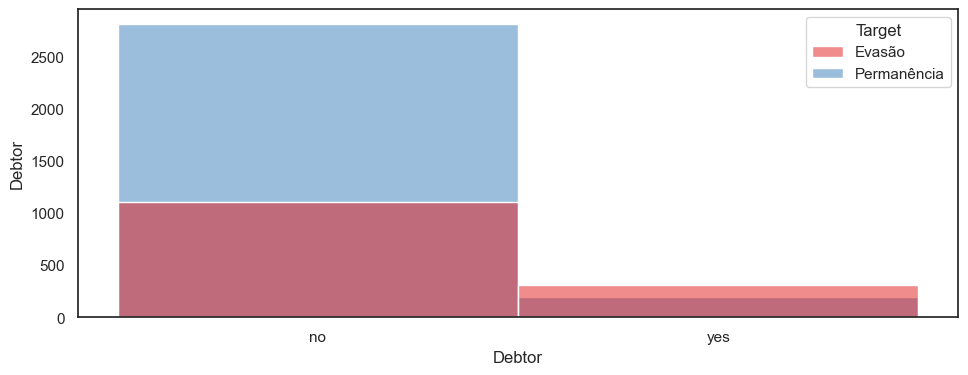

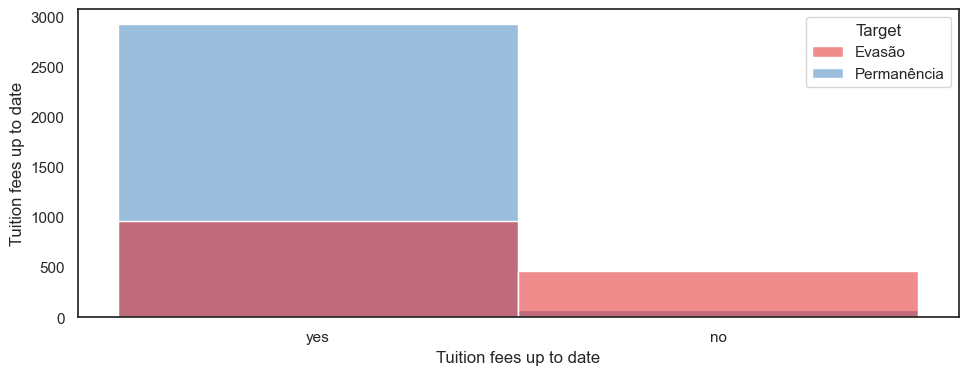

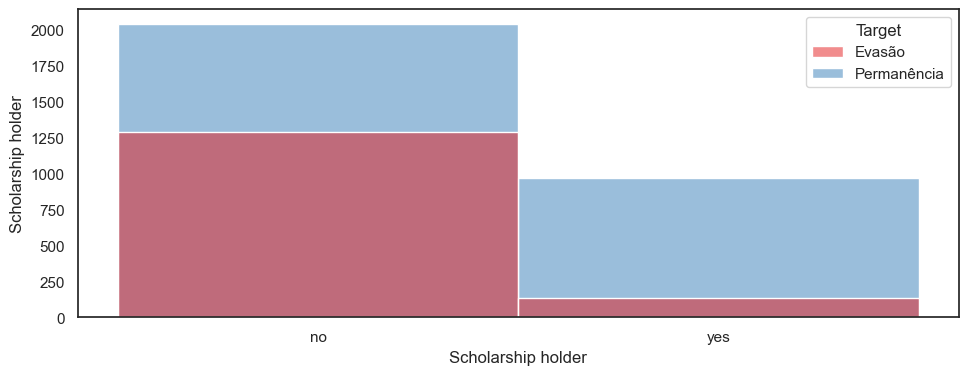

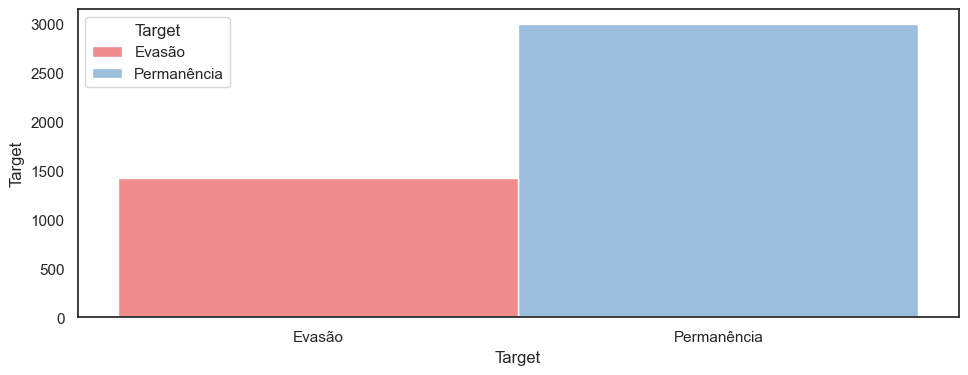

In [ ]:
# Referência: https://www.analyticsvidhya.com/blog/2022/07/step-by-step-exploratory-data-analysis-eda-using-python/

for col in categorical_data:
    
    # Atributo
    print(col, end="\n\n")

    # Estatísticas descritivas
    print('Moda :', round(data_cat[col].mode(), 2))
    print('Amostras únicas :', data_cat[col].nunique())
    print('Amostras faltando :', data_cat[col].isnull().sum())

    num_labels = data_cat[col].nunique()

    if num_labels > 7:

        width = max(5, num_labels)
        height = max(5, num_labels-10)

        plt.figure(figsize=(width*0.8, height*1.25))
        plt.subplot(1, 2, 1)
        sns.histplot(data=data_cat, y=col, kde=False, hue='Target', palette='Set1')
        plt.xticks(rotation=90)
        plt.ylabel(col)
        plt.show()

    else:
        plt.figure(figsize=(25, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(data=data_cat, x=col, kde=False, hue='Target', palette='Set1')
        plt.ylabel(col)
        plt.show()

## P4. Quais os padrões e anomalias entre todos os atributos?

- **Análise bivariada** quais as relações entre pares de atributos?

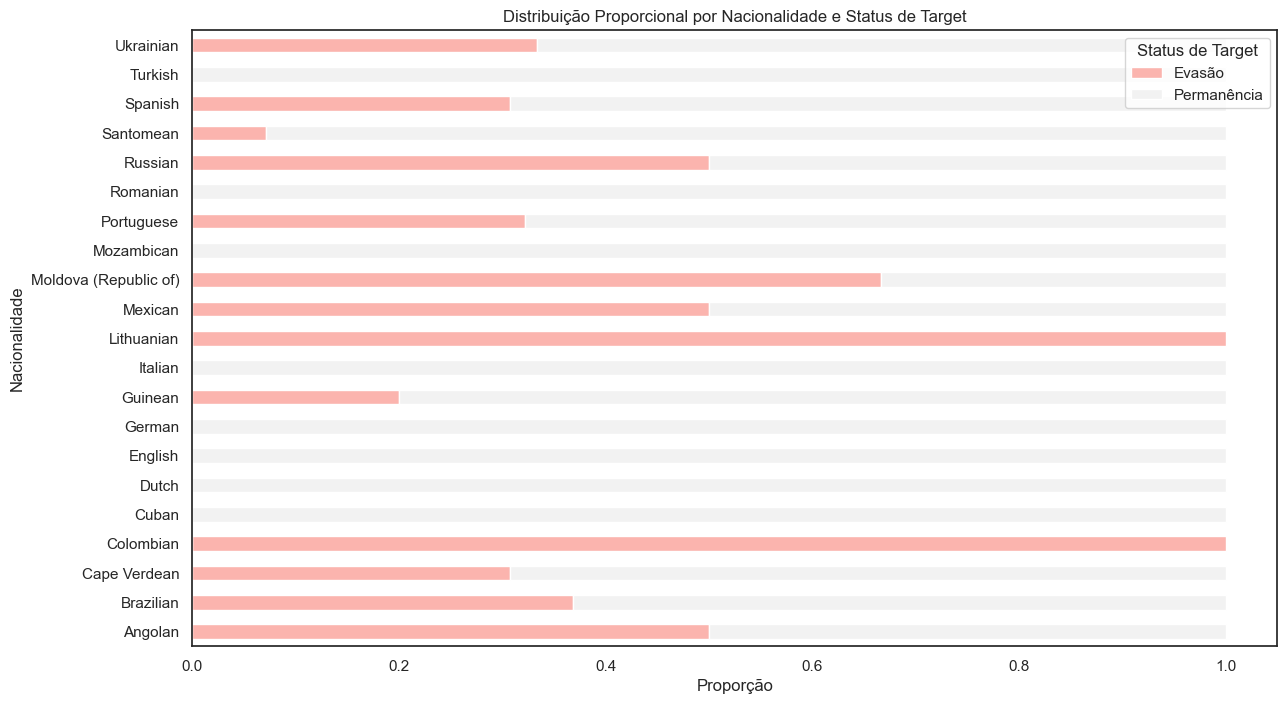

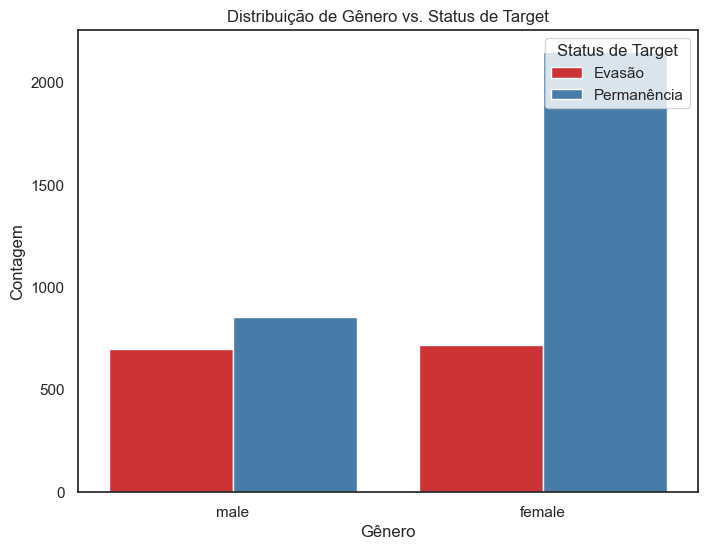

<<<<<<< local <modified: >


C:\Users\Matheus\AppData\Local\Temp\ipykernel_34588\3531639920.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_cat, x='Target', y='Age at enrollment', palette='Set1')


>>>>>>> remote <modified: >


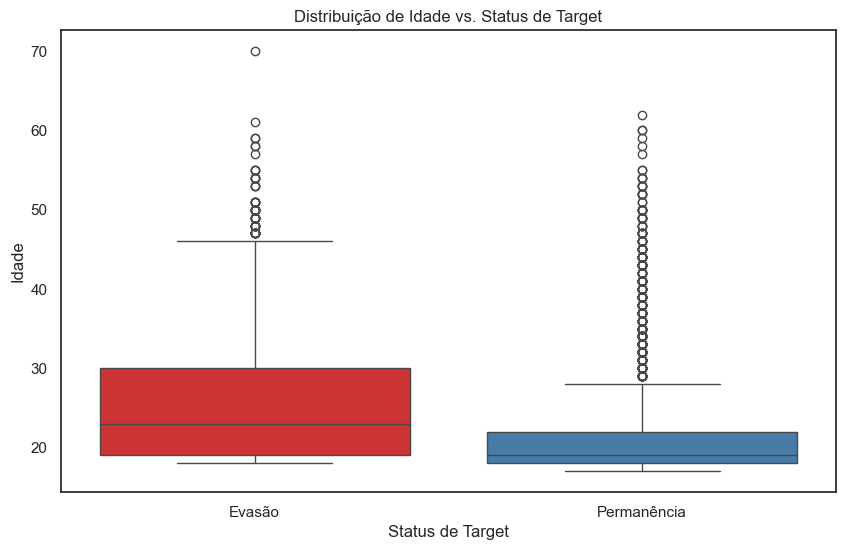

In [ ]:
# Agrupando os dados por Nacionalidade e Status de Target
stacked_data = data_cat.groupby(['Nacionality', 'Target']).size().unstack().fillna(0)

# Normalizando os dados para mostrar proporções em vez de contagens absolutas
normalized_data = stacked_data.div(stacked_data.sum(axis=1), axis=0)

print(stacked_data.head())

# Criando o gráfico de barras empilhadas normalizado
normalized_data.plot(kind='barh', stacked=True, figsize=(14, 8), colormap='Pastel1')

plt.title('Distribuição Proporcional por Nacionalidade e Status de Target')
plt.xlabel('Proporção')
plt.ylabel('Nacionalidade')
plt.legend(title='Status de Target', loc='upper right')
plt.show()

# Gráfico de Distribuição de Gênero vs. Status de Target
plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', hue='Target', data=data_cat, palette='Set1')
plt.title('Distribuição de Gênero vs. Status de Target')
plt.xlabel('Gênero')
plt.ylabel('Contagem')
plt.legend(title='Status de Target', loc='upper right')
plt.show()

# Idade
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_cat, x='Target', y='Age at enrollment', palette='Set1')
plt.title('Distribuição de Idade vs. Status de Target')
plt.xlabel('Status de Target')
plt.ylabel('Idade')
plt.show()

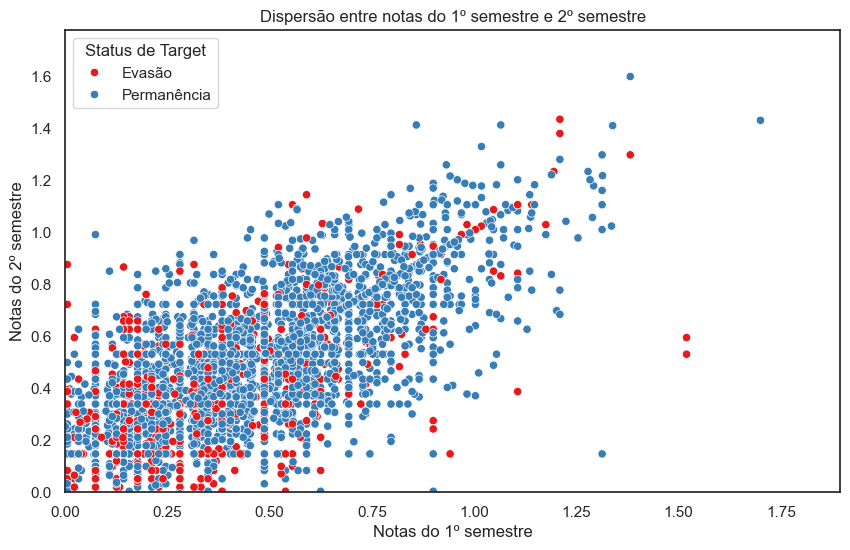

In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalize the data for x and y
scaler = StandardScaler()

# Create an empty DataFrame
normalized_df = pd.DataFrame()

normalized_df[['Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)']] = scaler.fit_transform(data[['Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)']])
normalized_df['Target'] = data['Target']

plt.figure(figsize=(10, 6))
sns.scatterplot(data=normalized_df, x='Curricular units 1st sem (grade)', y='Curricular units 2nd sem (grade)', hue='Target', palette='Set1')
plt.title('Dispersão entre notas do 1º semestre e 2º semestre')
plt.xlabel('Notas do 1º semestre')
plt.ylabel('Notas do 2º semestre')
plt.legend(title='Status de Target', loc='upper left')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

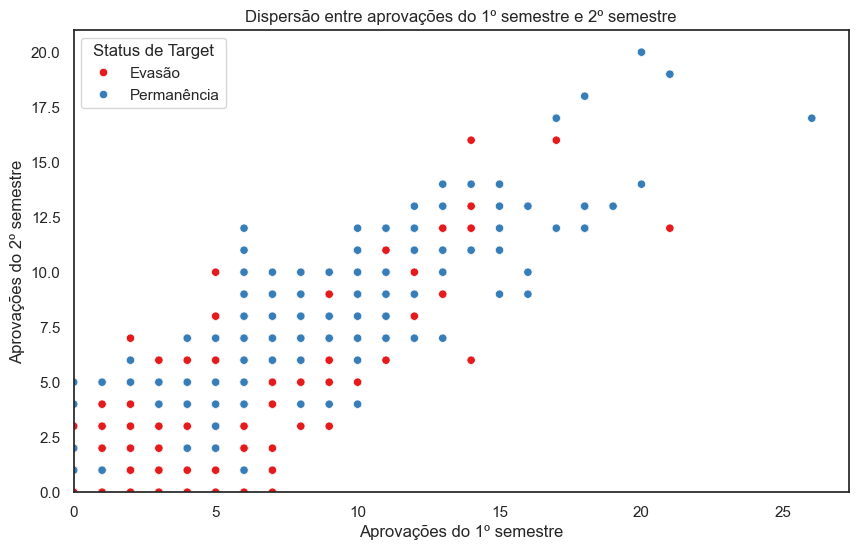

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Curricular units 1st sem (approved)', y='Curricular units 2nd sem (approved)', hue='Target', palette='Set1')
plt.title('Dispersão entre aprovações do 1º semestre e 2º semestre')
plt.xlabel('Aprovações do 1º semestre')
plt.ylabel('Aprovações do 2º semestre')
plt.legend(title='Status de Target', loc='upper left')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

- **Análise multivariada**: quais as relações entre as variáveis numéricas e categóricas?

Para podermos comparar variáveis numéricas e categóricas, precisamos mapear as strings categóricas para atributos numéricos. Como neste dataset, originalmente, as variáveis categóricas já estão mapeadas em valores numéricos discretos, precisamos apenas mapear o atributo alvo.

In [ ]:
# Podemos mudar essas strings para valores int
# Label encoding
data['Target'] = data['Target'].map({
    'Evasão':1,
    'Permanência':0
})

print(data["Target"].unique())

Com isto, avaliamos quais fatores influenciam diretamente a desistência dos alunos através do método de correlação de Pearson. Queremos visualizar a correlação entre os atributos. Para isto, criamos uma matriz de correlação diagonal.

In [ ]:
attribute_corr = data.corr(method = 'pearson') # Gera uma matriz de correlação e mostra apenas as correlações entre o Target e outras variáveis

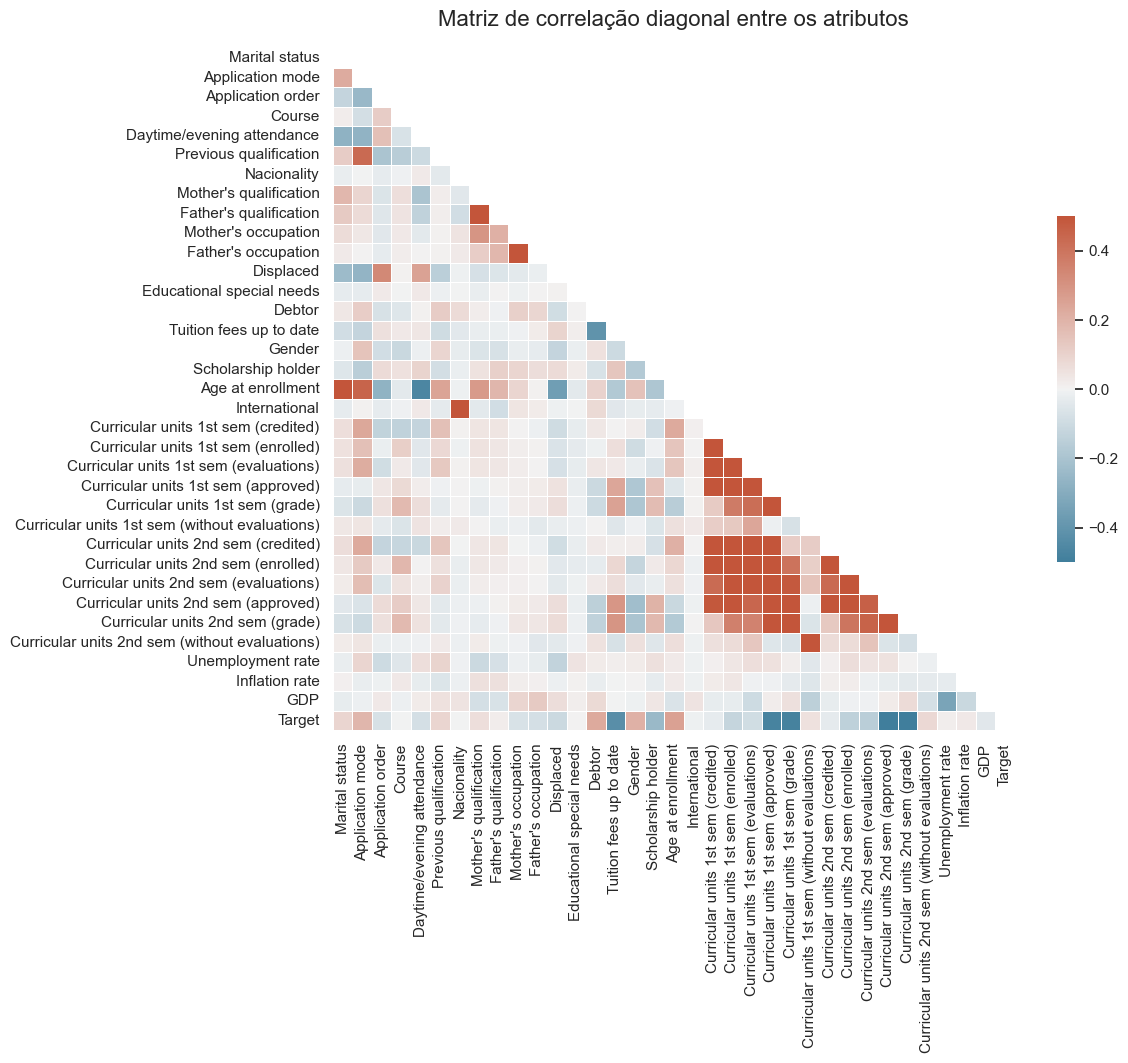

In [ ]:
# Plotting a diagonal correlation matrix: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
def diagonal_corr_matrix(df, title):
    sns.set_theme(style="white")

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(df, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    diag_heatmap = sns.heatmap(df, mask=mask, cmap=cmap, vmax=.5, vmin=-.5, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    diag_heatmap.set_title(title, fontdict={'fontsize':16}, pad=16)

diagonal_corr_matrix(attribute_corr, 'Matriz de correlação diagonal entre os atributos')

- Existem atributos redundantes, como International e Nacionality, que têm correlação considerável entre si
- Outras correlações significativas são óbvias, e poderiam ser úteis apenas para resumir dois atributos em um, se forem selecionados:
  - Age at enrollment vs Marital status
  - Age at enrollment vs Application mode
  - Mother's occupation vs Father's occupation
  - Mother's qualification vs Father's qualification
  - Curricular units 1st sem vs Curricular units 2nd sem
  - International vs Nationality
  - Curricular units 1st sem vs Curricular units 2nd sem

# 3. Pré-processamento dos dados

Aplique técnicas de pré-processamento nos dados a fim de melhorar a qualidade dos mesmos por meio da eliminação ou minimização de problemas identificados na etapa anterior. A avaliação deste trabalho não exigirá um pré-processamento aprofundado, por ser um tópico ainda pouco discutido na disciplina, mas será esperado que os grupos lidem com aspectos como a remoção de atributos ou instâncias problemáticas (por exemplo, por conterem muitos valores faltantes ou não parecerem informativas para o problema), normalização de atributos, balanceamento de classes, transformação de atributos de categórico para numérico, caso se mostrem necessários nos dados escolhidos.

- Remoção de atributos ou instâncias problemáticas
- Balanceamento de classes
- Transformação de atributos
- Normalização de atributos

## Remoção de atributos ou instâncias problemáticas

Na fase de EDA, identificamos instâncias discrepantes (outliers) em alguns atributos. Porém, nenhum se trata de valores inconsistentes ou erros.

Para a seleção de atributos, escolhemos a abordagem baseada em filtros, utilizando  a correlação de Pearson como métrica. Critérios mais avançados podem ser utilizados posteriormente, como aplicados em [1].

In [ ]:
old_data = data.copy(deep=True)

data = data.drop(columns=[  'Age at enrollment', "Father's occupation", "Father's qualification", "Nacionality",
                            "Curricular units 1st sem (enrolled)", "Curricular units 1st sem (evaluations)", "Curricular units 1st sem (credited)",
                            "Curricular units 1st sem (grade)", "Curricular units 1st sem (without evaluations)",
                            "Curricular units 1st sem (approved)", "Curricular units 2nd sem (enrolled)", "Curricular units 2nd sem (evaluations)", 
                            "Curricular units 2nd sem (credited)", "Curricular units 2nd sem (approved)"])

attribute_corr = data.corr(method = 'pearson') # Gera uma matriz de correlação e mostra apenas as correlações entre o Target e outras variáveis

diagonal_corr_matrix(attribute_corr, 'Matriz de correlação diagonal entre os atributos após remoção')

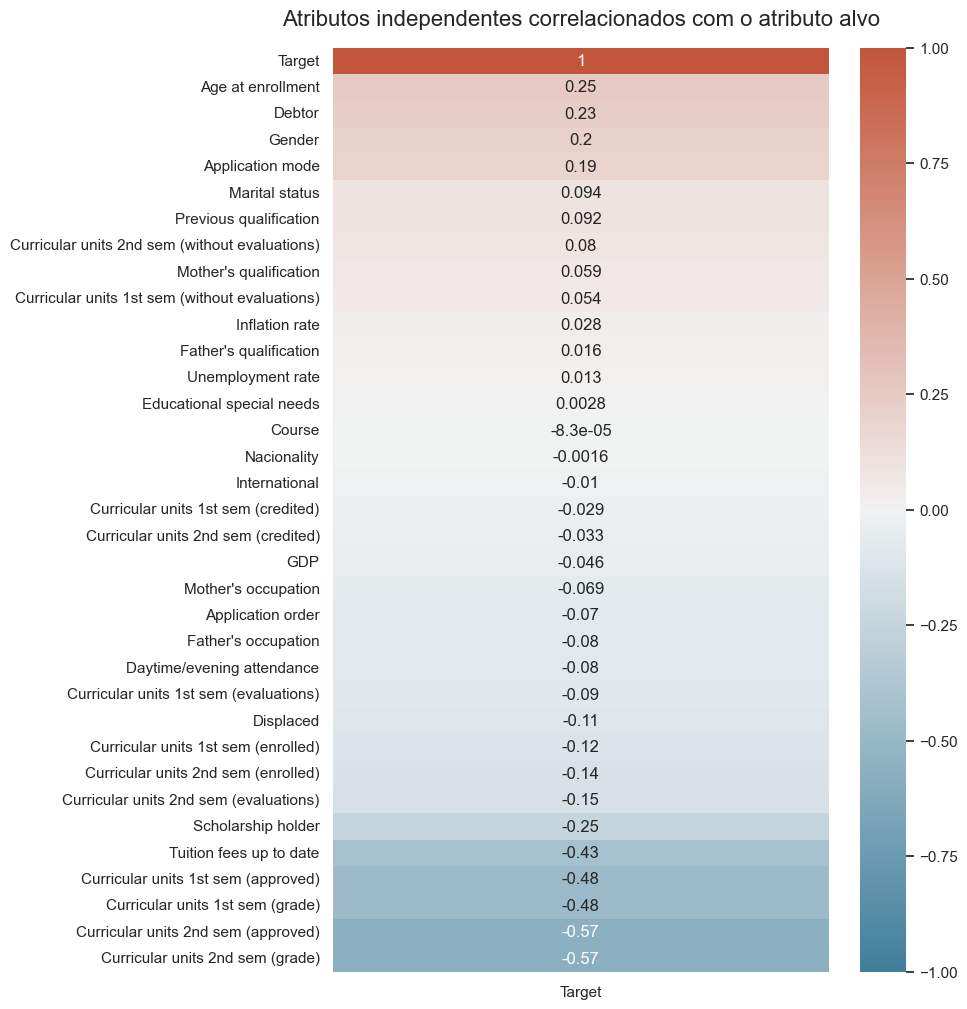

In [ ]:
# https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

attr_corr_target = data.corr()[['Target']].sort_values(by='Target', ascending=False)

print(attr_corr_target)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(attr_corr_target, vmin=-1, vmax=1, annot=True, cmap=cmap)
heatmap.set_title('Atributos independentes correlacionados com o atributo alvo', fontdict={'fontsize':16}, pad=16);

A classificação da correlação de Pearson pode entre diferentes autores e domínios. Podemos interpretar as correlações da seguinte maneira:

Interpretação convencional: https://journals.lww.com/anesthesia-analgesia/fulltext/2018/05000/correlation_coefficients__appropriate_use_and.50.aspx

| Coeficiente de correlação | Interpretação |
|----------------------|-------------|
| Muito forte       | 0.90 - 1.0      |
| Forte             | 0.70 - 0.89     |
| Moderada          | 0.40 - 0.69     |
| Fraca             | 0.10 - 0.39     |
| Desconsiderável   | 0.00 - 0.10     |


**Moderadas:**
- Tuition fees up to date                        -0.429149
- Curricular units 1st sem (approved)            -0.479112
- Curricular units 1st sem (grade)               -0.480669
- Curricular units 2nd sem (approved)            -0.569500
- Curricular units 2nd sem (grade)               -0.571792

**Fracas:**
- Age at enrollment                               0.254215
- Debtor                                          0.229407
- Gender                                          0.203983
- Application mode                                0.188908
- Displaced                                      -0.107232
- Curricular units 1st sem (enrolled)            -0.124635
- Curricular units 2nd sem (enrolled)            -0.141515
- Curricular units 2nd sem (evaluations)         -0.154999
- Scholarship holder                             -0.245354

**Desprezíveis:**
- Marital status                                  0.093712
- Previous qualification                          0.091590
- Curricular units 2nd sem (without evaluations)  0.079901
- Mother's qualification                          0.059499
- Curricular units 1st sem (without evaluations)  0.054230
- Inflation rate                                  0.027826
- Father's qualification                          0.016267
- Unemployment rate                               0.012980
- Educational special needs                       0.002806
- Course                                         -0.000083
- Nacionality                                    -0.001571
- International                                  -0.010360
- Curricular units 1st sem (credited)            -0.029308
- Curricular units 2nd sem (credited)            -0.033038
- GDP                                            -0.046319
- Mother's occupation                            -0.069102
- Application order                              -0.070485
- Father's occupation                            -0.079753
- Daytime/evening attendance                     -0.080499
- Curricular units 1st sem (evaluations)         -0.090125


Nesta análise, 20 dos 34 atributos mostraram correlação desprezível com o atributo alvo. Já os 9 atributos restantes apresentaram correlação fraca e 5 atributos correlação moderada.

In [ ]:
diverging_colors = sns.color_palette("RdBu", 10)
print(diverging_colors)
diverging_colors

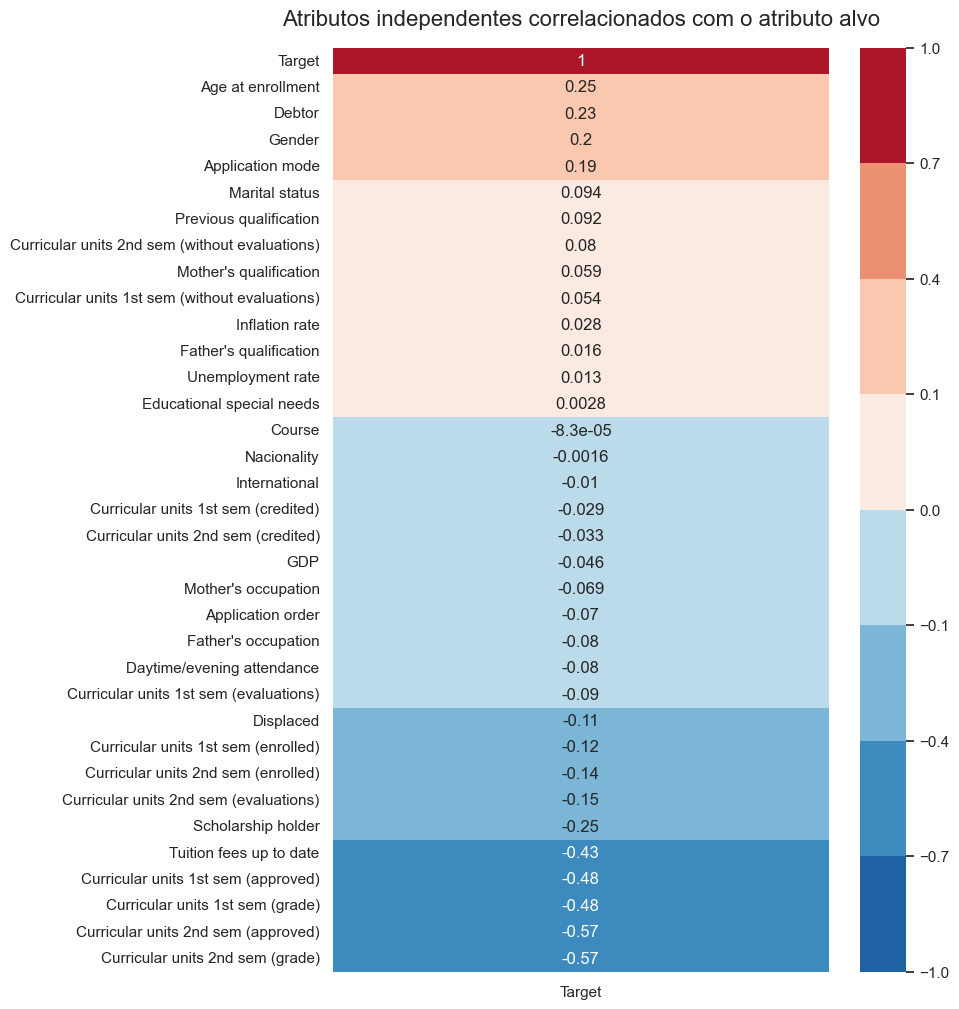

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
import seaborn as sns
import numpy as np

# Define colors and bounds for symmetric intervals
my_colors = sns.color_palette("RdBu", 10)[::-1]  # Invert the palette
my_cmap = ListedColormap(my_colors)
bounds = [-1, -0.7, -0.4, -0.1, 0, 0.1, 0.4, 0.7, 1]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

attr_corr_target = data.corr()[['Target']].sort_values(by='Target', ascending=False)

print(attr_corr_target)

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(attr_corr_target, vmin=-1, vmax=1, annot=True, cmap=my_cmap, norm=my_norm)
heatmap.set_title('Atributos independentes correlacionados com o atributo alvo', fontdict={'fontsize':16}, pad=16)
plt.show()

## Transformação de atributos

Com a seleção de atributos baseada em correlação com o alvo, não sobrou nenhuma coluna do tipo categórico binário para realizar transformação.

In [ ]:
# data[categorical_nominal].head()

In [ ]:
# # Perform one-hot encoding for columns in categorical_nominal
# data_encoded = pd.get_dummies(data, columns=categorical_nominal)

# # Display the first few rows of the encoded dataframe
# data_encoded.head()

One-hot encoding

In [ ]:
# # https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

# attr_corr_target = data_encoded.corr()[['Target']].sort_values(by='Target', ascending=False)

# print(attr_corr_target)

# plt.figure(figsize=(8, 50))
# heatmap = sns.heatmap(attr_corr_target, vmin=-1, vmax=1, annot=True, cmap=cmap)
# heatmap.set_title('Atributos independentes correlacionados com o atributo alvo', fontdict={'fontsize':16}, pad=16);

## Balanceamento de classes

Como observamos no EDA, temos um desbalanceamento entre as classes do atributo Target. Testamos técnicas de balanceamento nesta sub-seção.

SMOTE da classe minoritária + Random Undersampling da classe majoritária

In [ ]:
# # Separa atributos preditivos e atributo alvo
# X = data.drop('Target', axis=1)
# y = data['Target']

# print(y.value_counts())

# # Realiza o SMOTE
# # Referência https://www.geeksforgeeks.org/smote-for-imbalanced-classification-with-python/

# smote = SMOTE(sampling_strategy='minority') 
# x,y = smote.fit_resample(X,y)

# print(y.value_counts())

# random_under = RandomUnderSampler(sampling_strategy='majority')
# x,y = random_under.fit_resample(x,y)

# print(y.value_counts())

Resultado estranho, pois parece que o RandomUndersampling não teve efeito.

<<<<<<< local


<<<<<<< local <modified: >


>>>>>>> remote


<<<<<<< local <removed>


/tmp/ipykernel_302007/2649642949.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = y, data = x, legend=False, palette='Set1',


>>>>>>> remote <unchanged>


C:\Users\Matheus\AppData\Local\Temp\ipykernel_34588\2649642949.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = y, data = x, legend=False, palette='Set1',


>>>>>>> remote <modified: >


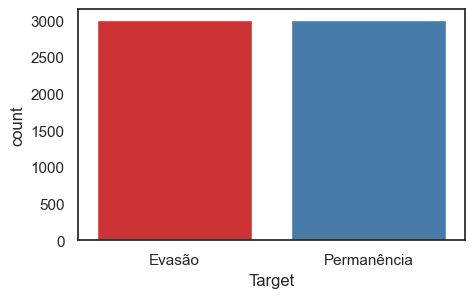

In [ ]:
# fig = plt.figure(figsize=(5, 3))

# sns.countplot(x = y, data = x, legend=False, palette='Set1',
#                 order=data['Target'].value_counts().index)

# plt.xticks([0, 1], ['Evasão', 'Permanência'])
# plt.show()

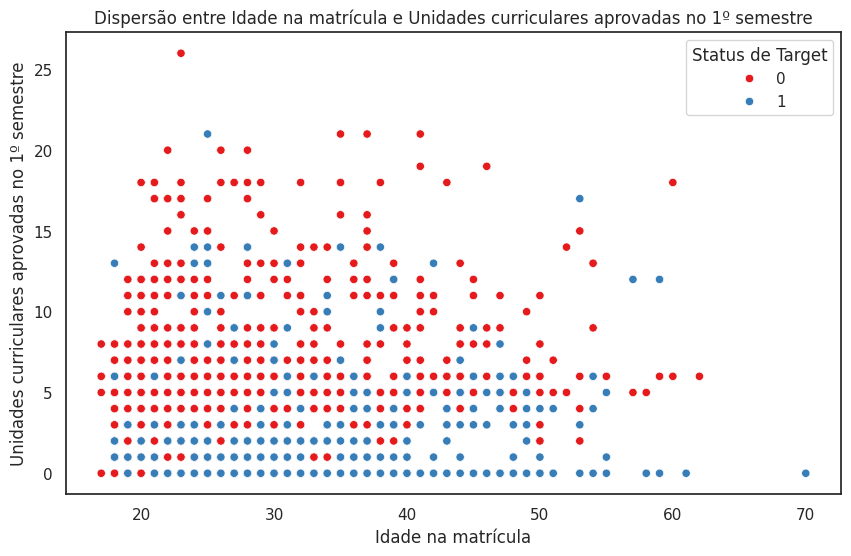

In [43]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Age at enrollment', y='Curricular units 1st sem (approved)', hue='Target', palette='Set1')
plt.title('Dispersão entre Idade na matrícula e Unidades curriculares aprovadas no 1º semestre')
plt.xlabel('Idade na matrícula')
plt.ylabel('Unidades curriculares aprovadas no 1º semestre')
plt.legend(title='Status de Target', loc='upper right')
plt.show()

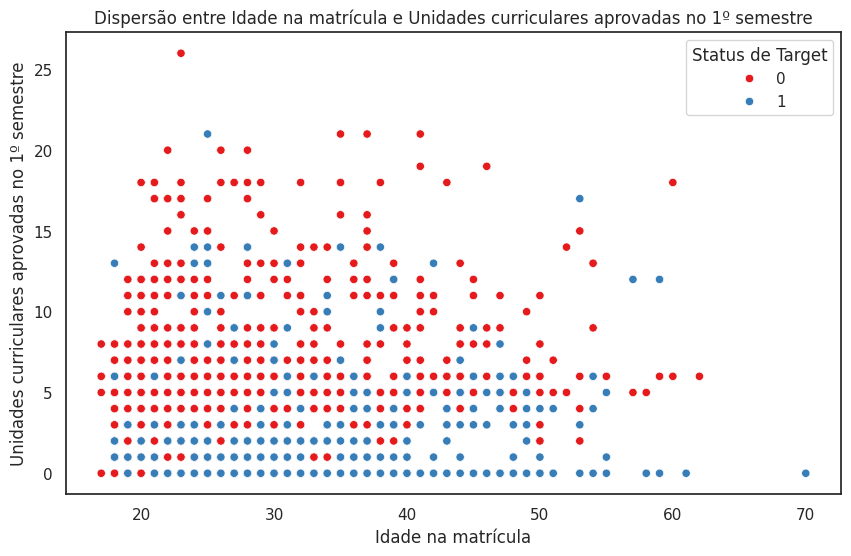

In [44]:
data.tail()
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Age at enrollment', y='Curricular units 1st sem (approved)', hue='Target', palette='Set1')
plt.title('Dispersão entre Idade na matrícula e Unidades curriculares aprovadas no 1º semestre')
plt.xlabel('Idade na matrícula')
plt.ylabel('Unidades curriculares aprovadas no 1º semestre')
plt.legend(title='Status de Target', loc='upper right')
plt.show()

**Conclusão: Adicionamos o SMOTE na pipeline, para evitar um vazamento de dados ao realizar o balanceamento em dados de treino e teste.**

## Normalização de atributos

Os dados numéricos deste dataset tem escalas bastante diferentes, como a ordem de aplicação, que é um atributo numérico ordinal, e as notas, que são atributos numéricos contínuos.

Os dados foram normalizados após o split, na seção [Spot-checking](#5-spot-checking), para não acontecer contaminação nos dados de teste pelas estimativas de média e desvio padrão.


In [1114]:
# numerical_data = ['Age at enrollment',
#  'Curricular units 1st sem (approved)',
#  'Curricular units 1st sem (grade)',
#  'Curricular units 2nd sem (approved)',
#  'Curricular units 2nd sem (grade)']

In [ ]:
# data[numerical_data].head()

Realizaremos uma normalização por min-max scaling e padronização por z-score. Porém, como o z-score estima a média e desvio padrão de cada atributo, isto pode significar um vazamento de dados ao realizar o split de dados após este processo.

# 4. Abordagem de aprendizado

Defina a abordagem de aprendizado de máquina que você planeja utilizar, isto é, se o problema é de classificação ou regressão. Justifique sua escolha com base na natureza do problema e nos dados disponíveis.
Selecione os algoritmos de aprendizado supervisionado a serem aplicados. Esta definição é de livre escolha do grupo, mas solicita-se que englobe algoritmos que constem no conteúdo programático da disciplina (podendo incluir de forma adicional outros algoritmos não abordados na disciplina).

Além disso, sugere-se selecionar um conjunto diversificado de algoritmos (em termos de viés indutivo), seguindo o propósito de spot-checking. Neste trabalho prático, os algoritmos podem ser aplicados como valores padrões de hiperparâmetros ou, se for a vontade do grupo, com uma variação mínima nos mesmos (como por exemplo, uma árvore de decisão sem poda e com uma poda não muito drástica). Os grupos devem comparar ao menos 5 algoritmos distintos.

Selecione as métricas de desempenho que serão usadas para avaliar os modelos a partir da definição da modelagem e da interpretação do problema a ser abordado. Neste processo, é recomendado utilizar mais de uma métrica para avaliação e comparação de modelos, mas selecionar uma métrica como critério principal de seleção de modelos (ou seja, aquela que o grupo tentará otimizar na análise de desempenho dos algoritmos). Escolha, também, a estratégia que aplicará para realizar a divisão de dados para treinamento e avaliação (holdout, cross-validation, etc..)

In [ ]:
# Algoritmos selecionados para treinamento
dtree = DecisionTreeClassifier(random_state=0)
dtree2 = DecisionTreeClassifier(random_state=0, max_depth=10)
rfc_gini = RandomForestClassifier(random_state=2)
rfc_entropy = RandomForestClassifier(random_state=2, criterion='entropy')
lr = LogisticRegression(random_state=42)
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_5 = KNeighborsClassifier(n_neighbors=5)
abc = AdaBoostClassifier(n_estimators=50,learning_rate=1, random_state=0, algorithm='SAMME')
svmachine = svm.SVC(kernel='linear',probability=True)

algo_dict = {'Decision Tree': dtree, 'Decision Tree Max depth 5': dtree2, 'Random Forest gini': rfc_gini, 'Random Forest entropy': rfc_entropy, 'Logistic Regression': lr, '3-Nearest Neighbors': knn_3, '5-Nearest Neighbors': knn_5, 'AdaBoost': abc, 'SVM': svmachine}

In [ ]:
# Referências
# https://machinelearningmastery.com/spot-check-machine-learning-algorithms-in-python/
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html


def make_pipeline(model):
    steps = list()

    steps.append(('Feature Selection', SelectKBest(k=10)))
    steps.append(('Normalização', StandardScaler()))
    steps.append(('Balanceamento da classe minoritária', SMOTE(sampling_strategy='minority')))
    steps.append(('Modelo', model))

    # Cria a pipeline
    pipe = Pipeline(steps=steps)

    return pipe

In [ ]:
from sklearn.model_selection import cross_validate

X = data.drop('Target', axis=1)
y = data['Target']

# Realiza a validação cruzada de um modelo, dado o número de folds e a métrica
def evaluate_model(X, y, algorithm, folds, metric):
    pipeline = make_pipeline(algorithm)
    scores = cross_validate(pipeline, X, y, cv=folds, n_jobs=-1,
                            scoring=metric, return_train_score=False,
                            return_estimator=True)
<<<<<<< local
    
    # # Print the output of SelectKBest for the first fold
    # first_estimator = scores['estimator'][0]
    # selected_features = first_estimator.named_steps['Feature Selection'].get_support(indices=True)
    # print("Selected features indices:", selected_features)
    # selected_columns = data.iloc[:, selected_features]
    
    return scores
=======
    return scores
>>>>>>> remote

# 5. Spot-checking

Execute a verificação rápida dos algoritmos através do treinamento e avaliação dos modelos de acordo com as definições do item anterior. Testar uma variedade de algoritmos permite que se possa identificar quais modelos têm o melhor desempenho inicial com os dados disponíveis. Isso economiza tempo e esforço ao focar em algoritmos que realmente têm potencial.
Recomenda-se a execução de múltiplas repetições do treinamento e avaliação usando cada algoritmo selecionado. É importante garantir a consistência dos resultados utilizando as mesmas divisões de dados em em uma determinada iteração para todos os algoritmos. Também é recomendado utilizar a definição manual de seeds em processos aleatórios (parâmetro random_state, no scikit-learn), para fins de reprodutibilidade dos experimentos. Lembre-se que neste trabalho prático não estamos interessados em realizar a otimização de hiperparâmetros ou a análise aprofundada dos modelos, como interpretabilidade dos mesmos.

Faça a sumarização dos resultados da avaliação dos modelos. O objetivo desta sumarização é identificar quais algoritmos se saíram melhor e merecem seguir para uma investigação mais detalhada, fazendo uma escolha informada de algoritmos para otimização de modelos. Atenção: esta investigação está fora do escopo do T1.
Para esta etapa, sugere-se o uso de sumarização por média e desvio padrão do desempenho, bem como gráficos do tipo box plot, violin plot, joy plot, etc, para visualização da distribuição de desempenho por modelo ao longo de n execuções. O uso de gráficos é importante pois viabiliza uma análise visual dos resultados.

In [ ]:
def evaluate_models(X, y, models, metrics_df, folds=10, metrics=['f1', 'precision', 'recall', 'roc_auc']):
    metrics_df = pd.DataFrame(columns=['Algoritmo', 'Fold'])

    for name, model in models.items():
        scores = evaluate_model(X, y, model, folds, metrics)
        scores['estimator'][0]
                                                                                                                                                                
        for fold in range(folds):
            fold_scores = {metric: scores[f'test_{metric}'][fold] for metric in metrics}
            fold_scores.update({'Algoritmo': name, 'Fold': fold})
            metrics_df = pd.concat([metrics_df, pd.DataFrame(fold_scores, index=[0])], ignore_index=True)

    return metrics_df, scores

def evaluate_models_repeated(X, y, models, folds=10, metrics=['f1', 'precision', 'recall', 'roc_auc'], repetitions=10):
    metrics_df = pd.DataFrame(columns=['Algoritmo', 'Fold', 'Rodada'])

    for run in range(repetitions):
        run_metrics_df, _ = evaluate_models(X, y, models, pd.DataFrame(columns=['Algoritmo', 'Fold']), folds, metrics)
        run_metrics_df['Rodada'] = run + 1
        metrics_df = pd.concat([metrics_df, run_metrics_df], ignore_index=True)

    return metrics_df

metrics_df = evaluate_models_repeated(X, y, algo_dict, folds=10, repetitions=10)

metrics_df

<<<<<<< local


<<<<<<< local <modified: text/html, text/plain>


>>>>>>> remote


<<<<<<< local <removed>


,Algoritmo,Fold,f1,precision,recall,roc_auc
0,Decision Tree,0,0.700337,0.675325,0.727273,0.773695
1,Decision Tree,1,0.747604,0.684211,0.823944,0.816317
2,Decision Tree,2,0.697674,0.660377,0.739437,0.766565
3,Decision Tree,3,0.695385,0.617486,0.795775,0.780532
4,Decision Tree,4,0.675079,0.611429,0.753521,0.754624
...,...,...,...,...,...,...
85,SVM,5,0.724739,0.717241,0.732394,0.874354
86,SVM,6,0.737931,0.722973,0.753521,0.870540
87,SVM,7,0.800000,0.843750,0.760563,0.898286
88,SVM,8,0.695312,0.780702,0.626761,0.859014


>>>>>>> remote <unchanged>


,Algoritmo,Fold,Rodada,f1,precision,recall,roc_auc,Run
0,Decision Tree,0,NaN,0.700680,0.682119,0.720280,0.777098,1.0
1,Decision Tree,1,NaN,0.737542,0.698113,0.781690,0.806256,1.0
2,Decision Tree,2,NaN,0.673267,0.633540,0.718310,0.745063,1.0
3,Decision Tree,3,NaN,0.685185,0.609890,0.781690,0.770074,1.0
4,Decision Tree,4,NaN,0.703583,0.654545,0.760563,0.781479,1.0
...,...,...,...,...,...,...,...,...
895,SVM,5,NaN,0.722222,0.712329,0.732394,0.874401,10.0
896,SVM,6,NaN,0.744681,0.750000,0.739437,0.871385,10.0
897,SVM,7,NaN,0.781609,0.857143,0.718310,0.898099,10.0
898,SVM,8,NaN,0.725352,0.725352,0.725352,0.862629,10.0


>>>>>>> remote <modified: text/html, text/plain>


In [243]:
# Aggregate and display results
for name, _ in algo_dict.items():
    metrics_per_model = metrics_df[metrics_df['Algoritmo'] == name]

    for metric in ['f1', 'precision', 'recall', 'roc_auc']:
        mean = float(round(metrics_per_model[metric].mean(), 3))
        std = float(round(metrics_per_model[metric].std(), 3))
        print(f'{metric.capitalize()} média do {name}: {mean} ({std})')

    print('\n')

F1 média do Decision Tree: 0.694 (0.029)
Precision média do Decision Tree: 0.648 (0.037)
Recall média do Decision Tree: 0.747 (0.031)
Roc_auc média do Decision Tree: 0.772 (0.024)


F1 média do Decision Tree Max depth 5: 0.727 (0.028)
Precision média do Decision Tree Max depth 5: 0.713 (0.041)
Recall média do Decision Tree Max depth 5: 0.744 (0.032)
Roc_auc média do Decision Tree Max depth 5: 0.823 (0.022)


F1 média do Random Forest gini: 0.75 (0.027)
Precision média do Random Forest gini: 0.747 (0.045)
Recall média do Random Forest gini: 0.754 (0.03)
Roc_auc média do Random Forest gini: 0.886 (0.015)


F1 média do Random Forest entropy: 0.75 (0.026)
Precision média do Random Forest entropy: 0.75 (0.042)
Recall média do Random Forest entropy: 0.753 (0.029)
Roc_auc média do Random Forest entropy: 0.887 (0.015)


F1 média do Logistic Regression: 0.757 (0.029)
Precision média do Logistic Regression: 0.749 (0.053)
Recall média do Logistic Regression: 0.767 (0.027)
Roc_auc média do Logisti

In [ ]:
for name, _ in algo_dict.items():
    metrics_per_model = metrics_df[metrics_df['Algoritmo'] == name]

    mean = float(round(metrics_per_model['f1'].mean(),3))
    std = float(round(metrics_per_model['f1'].std(),3))
    print(f'F1-Score do {name}: ', mean, f'({std})')

    mean = float(round(metrics_per_model['precision'].mean(),3))
    std = float(round(metrics_per_model['precision'].std(),3))
    print(f'Precisão média do {name}: ', mean, f'({std})')

    mean = float(round(metrics_per_model['recall'].mean(),3))
    std = float(round(metrics_per_model['recall'].std(),3))
    print(f'Recall média do {name}: ', mean, f'({std})')

    mean = float(round(metrics_per_model['roc_auc'].mean(),3))
    std = float(round(metrics_per_model['roc_auc'].std(),3))
    print(f'ROC AUC média do {name}: ', mean, f'({std})')

    print('\n')
print('\n')

<<<<<<< local


<<<<<<< local


>>>>>>> remote


<<<<<<< local <removed>


F1-Score do Decision Tree:  0.692 (0.027)
Precisão média do Decision Tree:  0.646 (0.033)
Recall média do Decision Tree:  0.748 (0.036)
ROC AUC média do Decision Tree:  0.77 (0.022)


F1-Score do Decision Tree Max depth 5:  0.729 (0.022)
Precisão média do Decision Tree Max depth 5:  0.72 (0.037)
Recall média do Decision Tree Max depth 5:  0.74 (0.029)
ROC AUC média do Decision Tree Max depth 5:  0.819 (0.024)


F1-Score do Random Forest gini:  0.75 (0.027)
Precisão média do Random Forest gini:  0.752 (0.044)
Recall média do Random Forest gini:  0.75 (0.03)
ROC AUC média do Random Forest gini:  0.888 (0.015)


F1-Score do Random Forest entropy:  0.748 (0.028)
Precisão média do Random Forest entropy:  0.747 (0.041)
Recall média do Random Forest entropy:  0.751 (0.032)
ROC AUC média do Random Forest entropy:  0.886 (0.015)


F1-Score do Logistic Regression:  0.758 (0.031)
Precisão média do Logistic Regression:  0.749 (0.056)
Recall média do Logistic Regression:  0.77 (0.029)
ROC AUC média

>>>>>>> remote <unchanged>


F1-Score do Decision Tree:  0.694 (0.029)
Precisão média do Decision Tree:  0.648 (0.037)
Recall média do Decision Tree:  0.747 (0.031)
ROC AUC média do Decision Tree:  0.772 (0.024)


F1-Score do Decision Tree Max depth 5:  0.727 (0.028)
Precisão média do Decision Tree Max depth 5:  0.713 (0.041)
Recall média do Decision Tree Max depth 5:  0.744 (0.032)
ROC AUC média do Decision Tree Max depth 5:  0.823 (0.022)


F1-Score do Random Forest gini:  0.75 (0.027)
Precisão média do Random Forest gini:  0.747 (0.045)
Recall média do Random Forest gini:  0.754 (0.03)
ROC AUC média do Random Forest gini:  0.886 (0.015)


F1-Score do Random Forest entropy:  0.75 (0.026)
Precisão média do Random Forest entropy:  0.75 (0.042)
Recall média do Random Forest entropy:  0.753 (0.029)
ROC AUC média do Random Forest entropy:  0.887 (0.015)


F1-Score do Logistic Regression:  0.757 (0.029)
Precisão média do Logistic Regression:  0.749 (0.053)
Recall média do Logistic Regression:  0.767 (0.027)
ROC AUC mé

>>>>>>> remote


Feedback T1: grid com todas as métricas, dividido por painéis

In [57]:
def letter_annotation(ax, xoffset, yoffset, letter):
 ax.text(xoffset, yoffset, letter, transform=ax.transAxes,
         size=12)

In [ ]:
fig = plt.figure(figsize=(10, 14))

# Cria 2 subfiguras para a primeira e segunda linha
(row1fig, row2fig) = fig.subfigures(2, 1, height_ratios=[1,1])

# Primeira linha
row1_axs = row1fig.subplots(1, 2)
row1fig.subplots_adjust(wspace=0.3, hspace=0.01, left=0, right=1.2, bottom=.3)

# Segunda linha
row2_axs = row2fig.subplots(1, 2)
row2fig.subplots_adjust(wspace=0.3, hspace=0.01, left=0, right=1.2, bottom=.3)

# F1-Score
# ============================================================
ax = row1_axs[0]
sns.boxplot(data=metrics_df, x='Algoritmo', y='f1', hue='Algoritmo', palette='Set3', ax=ax)
ax.tick_params(labelrotation=45)
ax.set_title('F1-Score por Algoritmo')
letter_annotation(ax, -.25, 1, 'a)')
sns.despine(offset=5, trim=False, ax=ax)

# Precisão
# ============================================================
ax = row1_axs[1]
sns.boxplot(data=metrics_df, x='Algoritmo', y='precision', hue='Algoritmo', palette='Set3', ax=ax)
ax.tick_params(labelrotation=45)
ax.set_title('Precisão por Algoritmo')
letter_annotation(ax, -.25, 1, 'b)')
sns.despine(offset=5, trim=False, ax=ax)

# Recall
# ============================================================
ax = row2_axs[0]
sns.boxplot(data=metrics_df, x='Algoritmo', y='recall', hue='Algoritmo', palette='Set3', ax=ax)
ax.tick_params(labelrotation=45)
ax.set_title('Revocação por Algoritmo')
letter_annotation(ax, -.25, 1, 'c)')
sns.despine(offset=5, trim=False, ax=ax)

# ROC AUC
# ============================================================
ax = row2_axs[1]
sns.boxplot(data=metrics_df, x='Algoritmo', y='roc_auc', hue='Algoritmo', palette='Set3', ax=ax)
ax.tick_params(labelrotation=45)
letter_annotation(ax, -.25, 1, 'd)')
sns.despine(offset=5, trim=False, ax=ax)

# ============================================================
plt.show()

Alternativamente, um **gráfico comicamente grande** com todas as métricas em um mesmo plot e figura.

In [ ]:
# merged boxplot by metric
metrics_long_df = metrics_df.melt(
    id_vars=["Algoritmo"],
    value_vars=["f1", "precision", "recall", "roc_auc"],
    var_name="Métrica",
    value_name="Valor"
)

plt.figure(figsize=(14, 8))
sns.boxplot(data=metrics_long_df, x="Métrica", y="Valor", hue="Algoritmo", palette="Set3")
plt.xticks(rotation=45)
plt.title("Boxplot das métricas dos algoritmos agrupadas por métrica")
plt.legend(title="Algoritmo")
plt.tight_layout()
plt.show()

In [ ]:
# boxplot for the top n
plt.figure(figsize=(12, 6))
sns.boxplot(data=metrics_df, x='Algoritmo', y='f1', hue='Algoritmo', palette='Set3')
plt.xticks(rotation=45)
plt.show()

# boxplot for the top n
plt.figure(figsize=(12, 6))
sns.boxplot(data=metrics_df, x='Algoritmo', y='precision', hue='Algoritmo', palette='Set3')
plt.xticks(rotation=45)
plt.show()

# boxplot for the top n
plt.figure(figsize=(12, 6))
sns.boxplot(data=metrics_df, x='Algoritmo', y='recall', hue='Algoritmo', palette='Set3')
plt.xticks(rotation=45)
plt.show()

# boxplot for the top n
plt.figure(figsize=(12, 6))
sns.boxplot(data=metrics_df, x='Algoritmo', y='roc_auc', hue='Algoritmo', palette='Set3')
plt.xticks(rotation=45)
plt.show()

Joy plot com joypy

<<<<<<< local


<<<<<<< local


>>>>>>> remote


<<<<<<< local <removed>


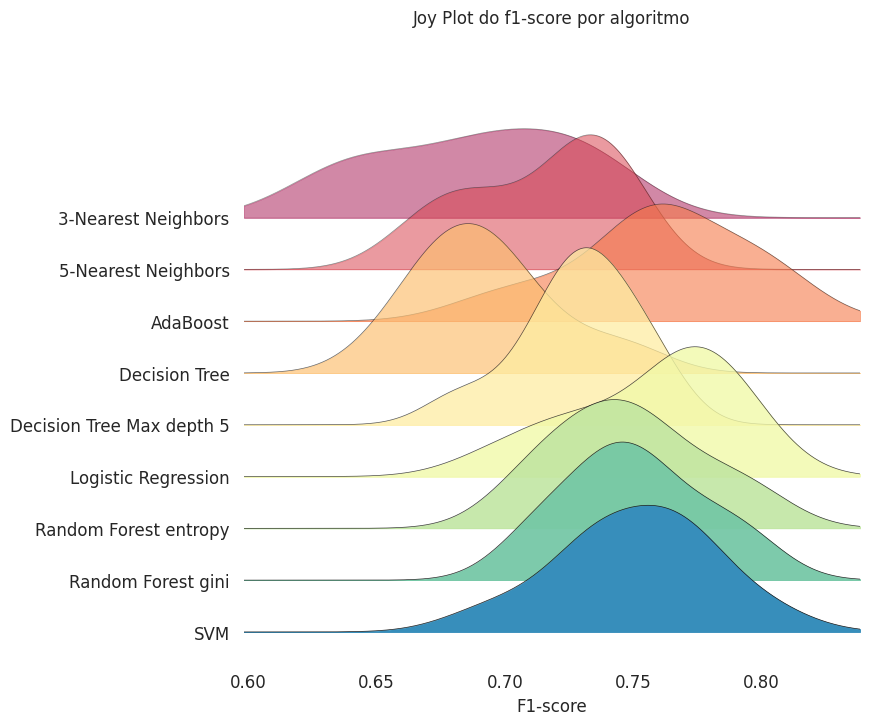

>>>>>>> remote <unchanged>


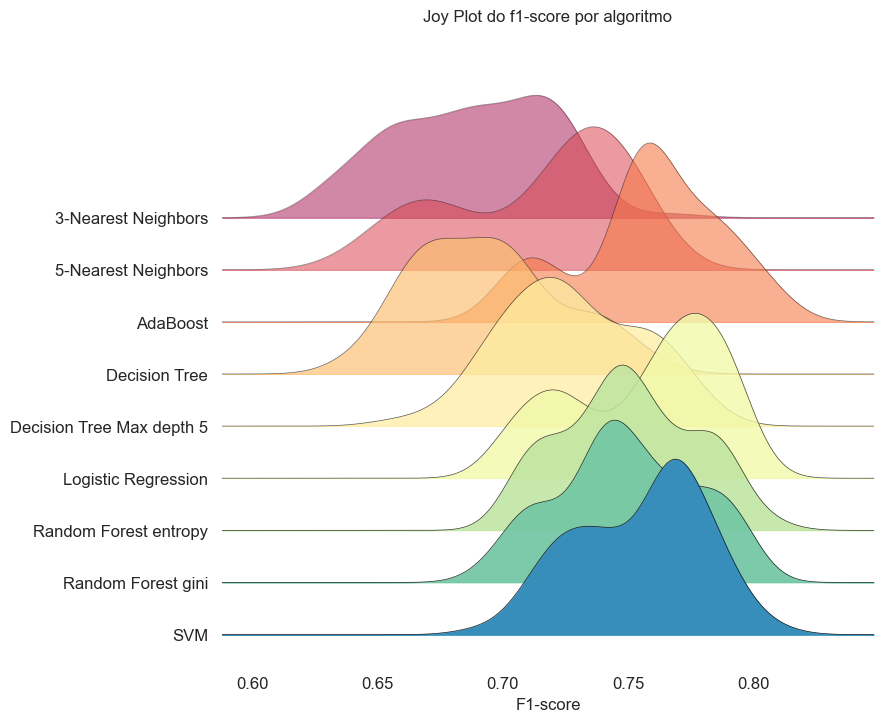

>>>>>>> remote


In [ ]:
#https://github.com/leotac/joypy/blob/master/Joyplot.ipynb

import joypy
import matplotlib.pyplot as plt

# Ensure 'Acurácia' column is numeric
metrics_df['f1'] = pd.to_numeric(metrics_df['f1'], errors='coerce')

# Prepare the data for the joy plot
data_for_joyplot = metrics_df.pivot(columns='Algoritmo', values='f1')

plt.figure(figsize=(19, 12))
joypy.joyplot(data_for_joyplot, colormap=plt.cm.Spectral, overlap=2, fade=True, linewidth=.5, figsize=(9,7))

plt.title('Joy Plot do f1-score por algoritmo')
plt.xlabel('F1-score')
plt.show()

# Exportando os dados pré-processados

Para serem utilizados no notebook [t2-otimizacao.ipynb](./t2-otimizacao.ipynb)

In [ ]:
data.to_csv('../data/clean-dataset.csv', index=False)  